## 2017 Leaf Morphometrics Analysis

This notebooke contains leaf shape analyses first year of Aim 1 of the NSF/PGRP project "Adapting Perennial Crops for Climate Change: Graft Transmissible Effects of Rootstocks on Grapevine Shoots" (1546869). The manuscript(s) associated with the data can be found in the README of this GitHIb repository.

This code is provided for reproducability.

Questions about this code and project can be directed to Zachary N. Harris or Allison J. Miller.

In [1]:
## Some functions get masked here. So it is worth being explicit for gather, select
library('rebus')
library('viridis')
library('tidyverse')
library('dplyr')
library('anomalize')
library('car')
library('corrplot')
library('randomForest')
library('MASS')
library('shapes')
library('ggplot2')
library('caret')

Loading required package: viridisLite
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.1.0     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::alpha() masks rebus::alpha()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ stringr::regex() masks rebus::regex()
══ Use anomalize to improve your Forecasts by 50%! ═════════════════════════════
Business Science offers a 1-hour course - Lab #18: Time Series Anomaly Detection!
</> Learn more at: https://university.business-science.io/p/learning-labs-pro </>
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some

corrplot 0.84 loaded
randomForest 4.6-14
Type rfNews() to see

In [2]:
#setwd('../leaf_shape/')

### Functions

In [2]:
plot_leaf <- function(leaf, title=''){
    vein_colour <- "mediumpurple3"
    margin_colour <- "forestgreen"

    p <- ggplot(leaf, aes(x=x1, y=y1, xend=x12, yend=y12)) + 
        geom_segment(colour=margin_colour) + 
        geom_segment(aes(x=x12, y=y12, xend=x10, yend=y10), colour=margin_colour) + 
        geom_segment(aes(x=x10, y=y10, xend=x8, yend=y8), colour=margin_colour) + 
        geom_segment(aes(x=x8, y=y8, xend=x6, yend=y6), colour=margin_colour) + 
        geom_segment(aes(x=x6, y=y6, xend=x4, yend=y4), colour=margin_colour) + 
        geom_segment(aes(x=x4, y=y4, xend=x2, yend=y2), colour=margin_colour) + 
        geom_segment(aes(x=x2, y=y2, xend=x3, yend=y3), colour=margin_colour) + 
        geom_segment(aes(x=x3, y=y3, xend=x5, yend=y5), colour=margin_colour) + 
        geom_segment(aes(x=x5, y=y5, xend=x7, yend=y7), colour=margin_colour) + 
        geom_segment(aes(x=x7, y=y7, xend=x9, yend=y9), colour=margin_colour) + 
        geom_segment(aes(x=x9, y=y9, xend=x11, yend=y11), colour=margin_colour) + 
        geom_segment(aes(x=x11, y=y11, xend=x1, yend=y1), colour=margin_colour) + 
        geom_segment(aes(x=x1, y=y1, xend=x13, yend=y13), colour=vein_colour) + 
        geom_segment(aes(x=x1, y=y1, xend=x14, yend=y14), colour=vein_colour) + 
        geom_segment(aes(x=x1, y=y1, xend=x15, yend=y15), colour=vein_colour) + 
        geom_segment(aes(x=x1, y=y1, xend=x16, yend=y16), colour=vein_colour) + 
        geom_segment(aes(x=x1, y=y1, xend=x17, yend=y17), colour=vein_colour) + 
        geom_segment(aes(x=x16, y=y16, xend=x11, yend=y11), colour=vein_colour) + 
        geom_segment(aes(x=x17, y=y17, xend=x12, yend=y12), colour=vein_colour) + 
        theme_bw() + ggtitle(title) + 
        coord_fixed(ratio=1)
    return(p)
}

## Load in Data Set

In [4]:
anthesis <- read.csv('2017_anthesis_reformat_subsampled_final.csv')
veraison <- read.csv('2017_veraison_reformat_subsampled_final.csv')
harvest  <- read.csv('2017_morphology_withPhenology_zh_reAnalysis_Harvest_reformat_leafRange_final.csv')
harvest$indexer <- paste(harvest$Row, harvest$Block, harvest$Rep, sep='')

anthesis$Phenology <- rep('Anthesis', dim(anthesis)[1])
veraison$Phenology <- rep('Veraison', dim(veraison)[1])
harvest$Phenology <- rep('Harvest', dim(harvest)[1])

df <- rbind(anthesis, veraison, harvest)
head(df)

Unnamed..0 label          Row Block Rep Leaf_range Leaf_index x1   y1   x2  
1 2248       8B11_5.jpeg     8  B     1   1_5        1           211  251  218
2 2261       8B18_9.jpeg     8  B     1   8_9        3          1814 2564 1866
3 2252       8B11_5.jpeg     8  B     1   1_5        2           878 1856  732
4 1446       10G41_6.jpeg   10  G     4   1_6        1           261  438  240
5    5       10G410_12.jpeg 10  G     4   10_12      3          2568 2040 2744
6 1459       10G47_9.jpeg   10  G     4   7_9        2          1014 1542 1194
  ⋯ x14  y14  x15  y15  x16  y16  x17  y17  indexer Phenology
1 ⋯  197  216  239  222  194  237  231  243 8B1     Anthesis 
2 ⋯ 1710 2448 1898 2456 1746 2568 1862 2572 8B1     Anthesis 
3 ⋯  780 1750 1016 1754  782 1872  980 1892 8B1     Anthesis 
4 ⋯  228  366  309  375  234  417  297  420 10G4    Anthesis 
5 ⋯ 2432 1864 2768 1896 2432 2040 2720 2072 10G4    Anthesis 
6 ⋯  864 1248 1284 1344  846 1482 1200 1596 10G4    Anthesis

In [5]:
meta <- read.csv('MtVernon_metadata.csv')
meta$indexer <- paste(meta$Row, meta$Block, meta$Rep, sep='')
meta$Row <- NULL
meta$Block <- NULL
meta$Rep <- NULL
meta$Time_block <- NULL

df <- merge(df, meta, on='indexer', how='left')
head(df)

indexer Unnamed..0 label         Row Block Rep Leaf_range Leaf_index x1      
1 10A1     316       10A11_3.jpg   10  A     1   1_3        2           983.000
2 10A1     315       10A11_3.jpg   10  A     1   1_3        1          1838.000
3 10A1     317       10A11_3.jpg   10  A     1   1_3        3          1037.000
4 10A1      34       10A110_15.jpg 10  A     1   10_15      2           654.000
5 10A1       1       10A11_9.jpg   10  A     1   1_9        1          2139.500
6 10A1    1315       10A11_7.jpg   10  A     1   1_7        1            21.333
  y1      ⋯ y14      x15      y15      x16  y16     x17      y17    Phenology
1 1788.00 ⋯ 1668.000 1085.000 1701.000  902 1785.00 1070.000 1806.0 Harvest  
2 1128.00 ⋯ 1082.000 1894.000 1084.000 1798 1134.00 1872.000 1134.0 Harvest  
3 3004.00 ⋯ 2875.000 1169.000 2881.000  914 3004.00 1148.000 3016.0 Harvest  
4 2924.00 ⋯ 2824.000  754.000 2804.000  540 2902.00  746.000 2892.0 Veraison 
5  144.75 ⋯  125.500 2148.250  126.750 2130  137.75 2148.750  138.5 Veraison 
6  292.00 ⋯  273.333   34.667  270.667    8  296.00   33.333  292.0 Anthesis 
  Rootstock Irrigation
1 3309C     Full      
2 3309C     Full      
3 3309C     Full      
4 3309C     Full      
5 3309C     Full      
6 3309C     Full

In [6]:
write.csv(df, file='Leaf_shape_metadata_check.csv')

In [7]:
## Niyati found an error where some plants in the 12G cell (the 1 reps) were being labelled SO4. That should be labelled 1103P. 

df$Rootstock[df$indexer == '12G1'] <- '1103P'
df[df$indexer == '12G1',]

indexer Unnamed..0 label        Row Block Rep Leaf_range Leaf_index x1    
774 12G1    1115       12G11_6.jpg  12  G     1   1_6        1           184.5
775 12G1    1121       12G17_8.jpg  12  G     1   7_8        2           672.0
776 12G1    2191       12G11_7.jpg  12  G     1   1_7        1          1964.0
777 12G1     345       12G11_3.jpg  12  G     1   1_3        1          1308.0
778 12G1    1254       12G19_12.jpg 12  G     1   9_12       3          1932.0
779 12G1     346       12G11_3.jpg  12  G     1   1_3        2          1638.0
780 12G1     347       12G11_3.jpg  12  G     1   1_3        3          1244.0
781 12G1    2199       12G18_9.jpg  12  G     1   8_9        3          1098.0
782 12G1    2195       12G11_7.jpg  12  G     1   1_7        2          1778.0
    y1   ⋯ y14  x15    y15  x16  y16    x17  y17  Phenology Rootstock
774  305 ⋯  281  190.5  274  166  309.5  199  294 Anthesis  1103P    
775 1128 ⋯  954  810.0  996  552 1134.0  768 1140 Anthesis  1103P    
776  578 ⋯  502 2010.0  510 1930  576.0 1996  572 Veraison  1103P    
777  822 ⋯  806 1316.0  786 1283  826.0 1322  815 Harvest   1103P    
778 3066 ⋯ 3096 1920.0 2934 1884 3126.0 1968 3030 Anthesis  1103P    
779 2055 ⋯ 1911 1766.0 1955 1566 2015.0 1698 2055 Harvest   1103P    
780 2913 ⋯ 2817 1330.0 2853 1200 2891.0 1290 2923 Harvest   1103P    
781 2450 ⋯ 2372 1170.0 2294 1038 2462.0 1176 2417 Veraison  1103P    
782 1739 ⋯ 1653 1862.0 1637 1706 1749.0 1838 1733 Veraison  1103P    
    Irrigation
774 Full      
775 Full      
776 Full      
777 Full      
778 Full      
779 Full      
780 Full      
781 Full      
782 Full

### Data summary

In [8]:
table(df$Row)
table(df$Block)
table(df$Leaf_index)
table(df$Rootstock)
table(df$Irrigation)
table(df$Phenology)


  8   9  10  11  12  13  14  15  16 
281 262 284 284 274 267 249 243 278 


  -   A   B   C   D   E   F   G   H 
  0 314 294 297 306 297 315 302 297 


  1   2   3  10  11  13  14  15  18  25  26  33 
793 814 794   2   4   2   3   4   1   3   1   1 


1103P 3309C   Own   SO4 
  597   610   593   622 


Full None  RDI 
 836  791  795 


Anthesis  Harvest Veraison 
     721      863      838 

In [9]:
morpho_meta <- df %>% dplyr::select(indexer, Row:Leaf_index, Phenology:Irrigation)
Leaf_index_tmp <- morpho_meta$Leaf_index
Leaf_index_tmp[Leaf_index_tmp > 3] <- 3
morpho_meta$Leaf_index <- Leaf_index_tmp
morpho <- df %>% dplyr::select(x1:y17)
table(Leaf_index_tmp)

Leaf_index_tmp
  1   2   3 
793 814 815 

## Generalized Procrustes Analysis

In [10]:
n_landmarks <- 17
n_leaves <- dim(morpho)[1]

# Apprently we can't be elegant. Write the table, and then call read.in to read it back in. 
write.table(as.matrix(morpho), col.names=F, row.names=F, file='2017_morphology_full_reAnalysis_final.txt')
morpho_reformat_gpa <- read.in('2017_morphology_full_reAnalysis_final.txt', n_landmarks, 2)

# looks right, I guess
dim(morpho_reformat_gpa)

# fit the GPA
GPA <- procGPA(morpho_reformat_gpa, reflect=TRUE)

# # write things a la Dan
write.csv(as.matrix(GPA$stdscores), file="2017_morphology_PC_scores.csv", quote=FALSE)
write.csv(as.matrix(GPA$percent), file="2017_morphology_PC_percents", quote=FALSE)
write.csv(as.matrix(GPA$rotated), file="2017_morphology_GPA_rotated.csv", quote=FALSE)

[1]   17    2 2422

[1] "To speed up use option distances=FALSE"
[1] "To speed up use option pcaoutput=FALSE"


In [11]:
# forced restructring of rotated matrix

#morpho_GPA_rotated_flat <- matrix(nrow=n_leaves, ncol=(n_landmarks*2))
morpho_GPA_rotated_flat <- matrix(nrow=n_leaves, ncol=(n_landmarks*2))

morpho_GPA_rotated <- as.matrix(GPA$rotated)
for(j in c(1:n_leaves)) {
    # extract all coordinates from the original table as blocks of 34 (n_landmarks*2) rows,
    # each representing the x coordinates of a leaf, one by one, as calculated from j.
    sub.data <- as.matrix(morpho_GPA_rotated[ (1+34*(j-1)):((1+34*(j-1))+33), 1])
    sub.data.x <- as.matrix(sub.data[1:n_landmarks,])
    sub.data.y <- as.matrix(sub.data[(n_landmarks+1):(n_landmarks*2),])

    # dissect out each x and y coordinate of the landmark data and put it into every other 
    # column of a single row (for a single leaf) in the overall table

    for (i in 1:n_landmarks){
        morpho_GPA_rotated_flat[j,(i*2-1)] <- sub.data.x[i, 1]
        morpho_GPA_rotated_flat[j, (i*2)] <- sub.data.y[i, 1]
    }
}

colnames(morpho_GPA_rotated_flat) <- c("x1", "y1", "x2", "y2", "x3", "y3", "x4", "y4", "x5", "y5", "x6", "y6", "x7", "y7", "x8", "y8", "x9", "y9", "x10", "y10", "x11", "y11", "x12", "y12", "x13", "y13", "x14", "y14", "x15", "y15", "x16", "y16", "x17", "y17")

head(morpho_GPA_rotated_flat)

x1         y1       x2         y2        x3        y3        x4      
[1,]   4.076085 176.4594  77.899009 -560.5686 -294.6196 -346.3634 313.9383
[2,]   5.602740 188.3621 -35.620933 -560.1121 -323.0555 -303.1318 305.4113
[3,]   5.770952 169.1370   5.076036 -523.9108 -282.9875 -334.5970 329.9751
[4,] -17.976605 228.1784 -45.767064 -566.5141 -203.9399 -272.9227 209.3214
[5,]   3.764729 318.7619 -19.210539 -841.2901 -172.6899 -199.1044 178.6628
[6,]   1.773621 221.3177   1.228519 -738.5560 -244.5277 -366.9135 241.3759
     y4        x5        y5        ⋯ x13         y13       x14        y14      
[1,] -283.8871 -374.6877 -437.4133 ⋯ -15.7822209  12.87689  -97.39658 100.69530
[2,] -320.5406 -409.9676 -348.2512 ⋯   8.0196145 -12.05784  -93.94470  98.05791
[3,] -314.2806 -359.1476 -393.5667 ⋯ -13.4070982 -15.47580  -98.83387  90.29846
[4,] -288.0003 -322.1908 -361.8489 ⋯  -1.5501574  31.15752  -99.72508 128.82107
[5,] -163.2748 -428.4283 -395.8609 ⋯  14.8456251  71.89030  -68.77469 123.33220
[6,] -240.8252 -393.3221 -395.2631 ⋯   0.5886491  23.82343 -114.44755  80.59527
     x15       y15       x16        y16      x17      y17     
[1,]  67.92491  87.95395  -60.55615 189.7378 76.35123 173.8833
[2,] 113.33881 111.95295  -69.03798 195.8369 68.03742 202.5698
[3,]  86.41577  61.94631  -84.26798 185.1194 88.58485 163.4982
[4,]  82.62712 137.86522 -112.87261 195.1275 64.80734 212.2378
[5,]  91.59421 134.98797  -93.38815 248.1669 97.47729 254.5314
[6,] 108.36514  91.68283  -89.87538 236.2899 81.15757 231.6581

x1        y1       x2       y2        x3        y3        x4      
mean_leaf 0.7436595 211.2756 2.658131 -558.0245 -237.7544 -281.5917 237.2888
          y4       x5        y5        ⋯ x13        y13      x14      y14     
mean_leaf -284.806 -394.3981 -370.7721 ⋯ -0.4131722 18.10576 -98.3129 105.8355
          x15      y15      x16       y16      x17      y17   
mean_leaf 95.12899 107.2315 -72.81292 208.9333 71.09315 209.64

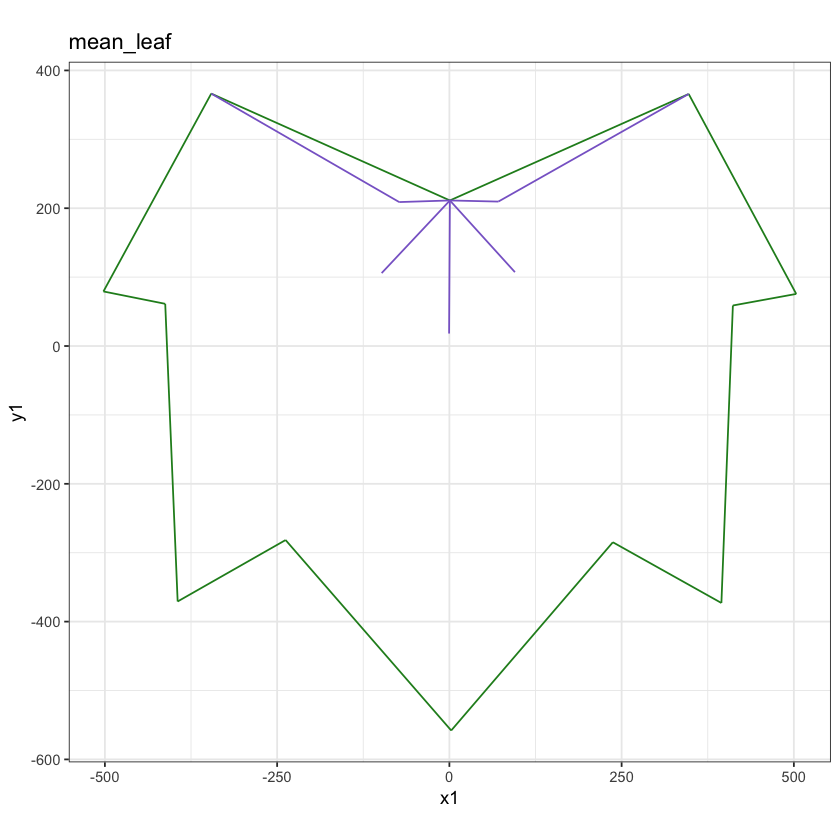

In [12]:
## Sanity check 

mean_leaf <- colMeans(morpho_GPA_rotated_flat)#colMeans(select(as.data.frame(morpho_GPA_rotated_flat), x1:y17))
mean_leaf_plot <- as.data.frame(t(as.data.frame(mean_leaf)))
mean_leaf_plot

plot_leaf(mean_leaf_plot, title='mean_leaf')

## PCA on GPA Space

In [13]:
pdf('2017_shapePCA_movie_1.pdf', onefile=T)
shapepca(GPA, pcno=c(1), type='m',
         joinline=c(1,13,2,3,5,7,9,11,1,12,10,8,6,4,2,13,1,16,9,11,16,1,17,10,12,17,1,14,5,3,2,13,1,15,6))
dev.off()

pdf('2017_shapePCA_movie_2.pdf', onefile=T)
shapepca(GPA, pcno=c(2), type='m',
         joinline=c(1,13,2,3,5,7,9,11,1,12,10,8,6,4,2,13,1,16,9,11,16,1,17,10,12,17,1,14,5,3,2,13,1,15,6))
dev.off()

pdf('2017_shapePCA_movie_3.pdf', onefile=T)
shapepca(GPA, pcno=c(3), type='m',
         joinline=c(1,13,2,3,5,7,9,11,1,12,10,8,6,4,2,13,1,16,9,11,16,1,17,10,12,17,1,14,5,3,2,13,1,15,6))
dev.off()

PC  1  


pdf 
  2

PC  2  


pdf 
  2

PC  3  


pdf 
  2

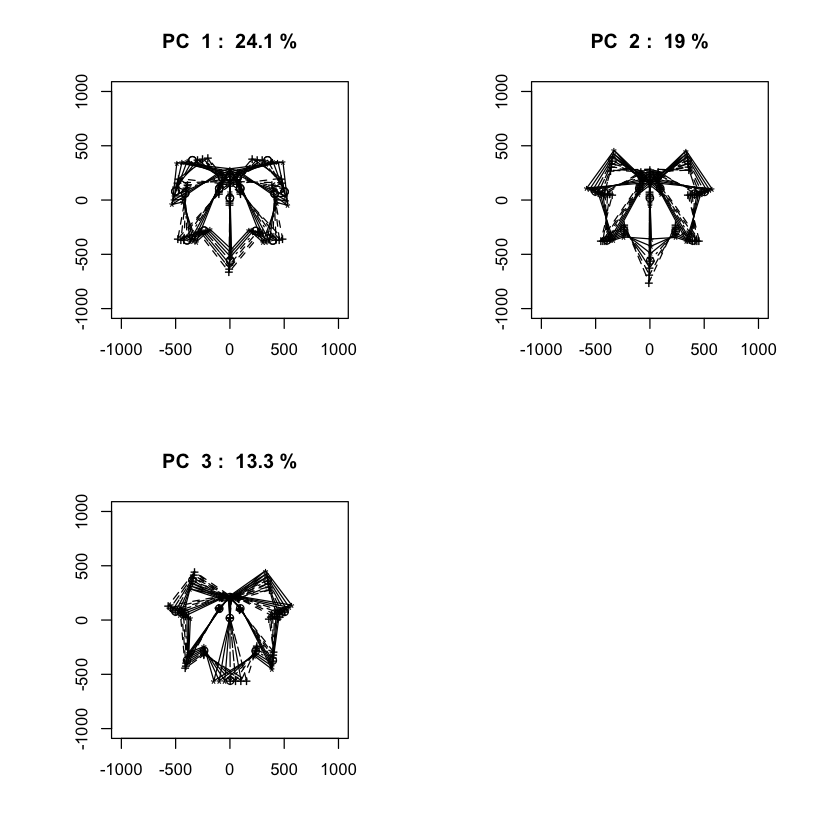

In [14]:
shapepca(GPA, pcno=c(1,2,3), type='s',
         joinline=c(1,13,2,3,5,7,9,11,1,12,10,8,6,4,2,13,1,16,9,11,16,1,17,10,12,17,1,14,5,3,2,13,1,15,6))

In [15]:
data.frame(x=1:20, y=as.matrix(GPA$percent)[1:20,])

x  y         
1   1 24.0583527
2   2 18.9580026
3   3 13.3365155
4   4  8.2126384
5   5  4.9792449
6   6  4.6345553
7   7  4.0620546
8   8  2.9247085
9   9  2.8617936
10 10  2.3103409
11 11  2.0097620
12 12  1.5913831
13 13  1.4184423
14 14  1.2885625
15 15  1.1712056
16 16  0.8418157
17 17  0.7781894
18 18  0.6584844
19 19  0.5999306
20 20  0.5536928

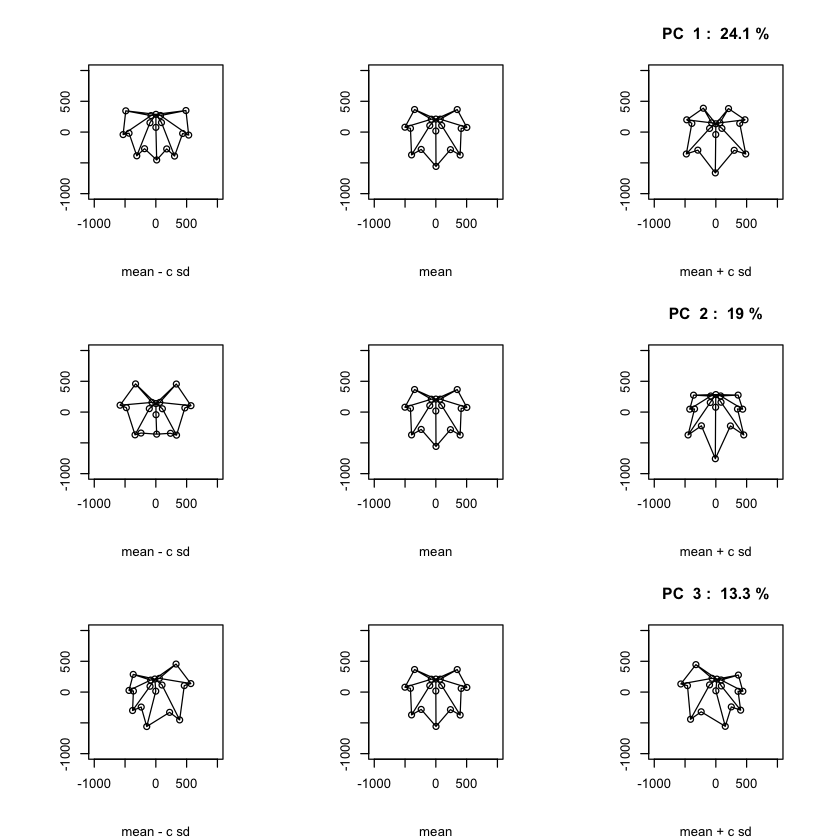

In [16]:
shapepca(GPA, pcno=c(1,2,3), type='r',
         joinline=c(1,13,2,3,5,7,9,11,1,12,10,8,6,4,2,13,1,16,9,11,16,1,17,10,12,17,1,14,5,3,2,13,1,15,6))

In [17]:
morpho_pcs <- as.data.frame(GPA$stdscores) %>% dplyr::select(PC1:PC20)
morpho_pcs <- cbind(morpho_pcs, morpho_meta)
head(morpho_pcs)

PC1        PC2         PC3        PC4        PC5        PC6        PC7       
1  0.9324449 -0.60688084  1.9614914 -0.1984240  0.4691079  1.3861683  0.7242354
2  0.8616283 -0.05925194 -0.5068459  0.9139727  1.0735512  0.9634443  0.3305268
3  1.1542901 -0.96611118  0.8729186  0.2613152  1.0710327  0.6930301  1.2977037
4 -0.8120195  0.09368730 -0.4405114  0.1013432  0.1536768 -0.8598116  0.9382306
5  0.8401290  3.58173733 -0.4418505 -2.5872248 -0.7629798 -0.0239587 -0.4964586
6  1.6039125  1.78872739  0.6220883 -1.4304472  1.6730802 -0.1248603  0.9072166
  PC8         PC9          PC10       ⋯ PC20        indexer Row Block Rep
1  1.13304003  0.572659592 -0.6941878 ⋯  0.62719180 10A1    10  A     1  
2 -0.03026029 -0.243178678 -0.3993828 ⋯ -0.63303042 10A1    10  A     1  
3  0.28158444  0.002601109  0.7589062 ⋯ -0.08054424 10A1    10  A     1  
4  1.39507715 -0.548777316  1.1158324 ⋯  0.47175490 10A1    10  A     1  
5  0.35909591  0.457372828 -0.3505761 ⋯ -1.66701872 10A1    10  A     1  
6  1.47231747 -0.347546676 -0.7759026 ⋯ -3.77696468 10A1    10  A     1  
  Leaf_range Leaf_index Phenology Rootstock Irrigation
1 1_3        2          Harvest   3309C     Full      
2 1_3        1          Harvest   3309C     Full      
3 1_3        3          Harvest   3309C     Full      
4 10_15      2          Veraison  3309C     Full      
5 1_9        1          Veraison  3309C     Full      
6 1_7        1          Anthesis  3309C     Full

In [18]:
write.csv(morpho_pcs, file='2017_GPA_rotated_PCs.csv', quote=F)

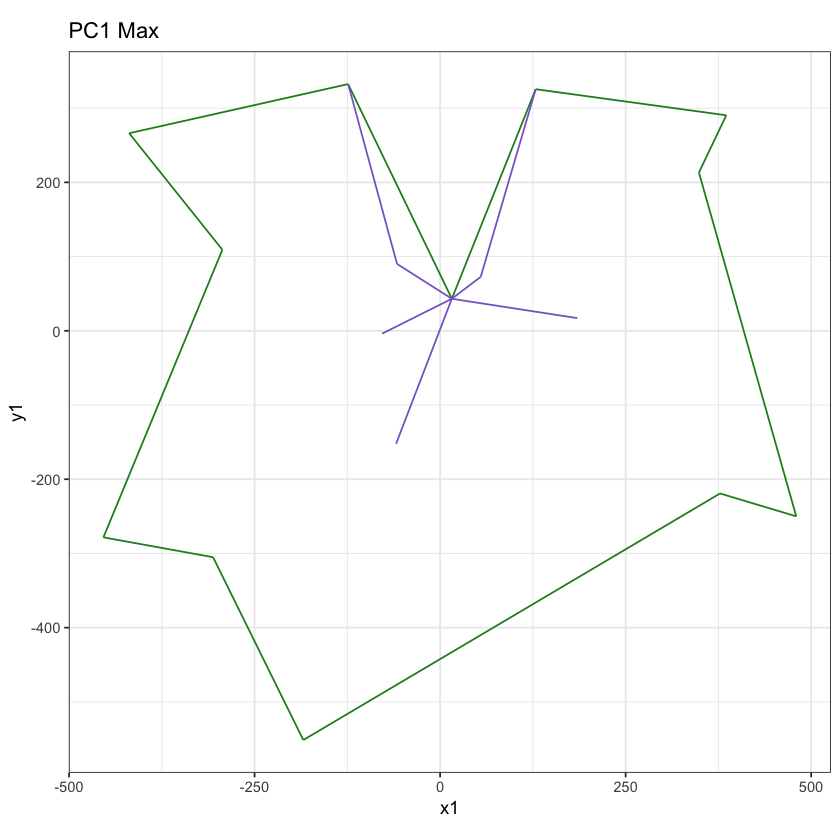

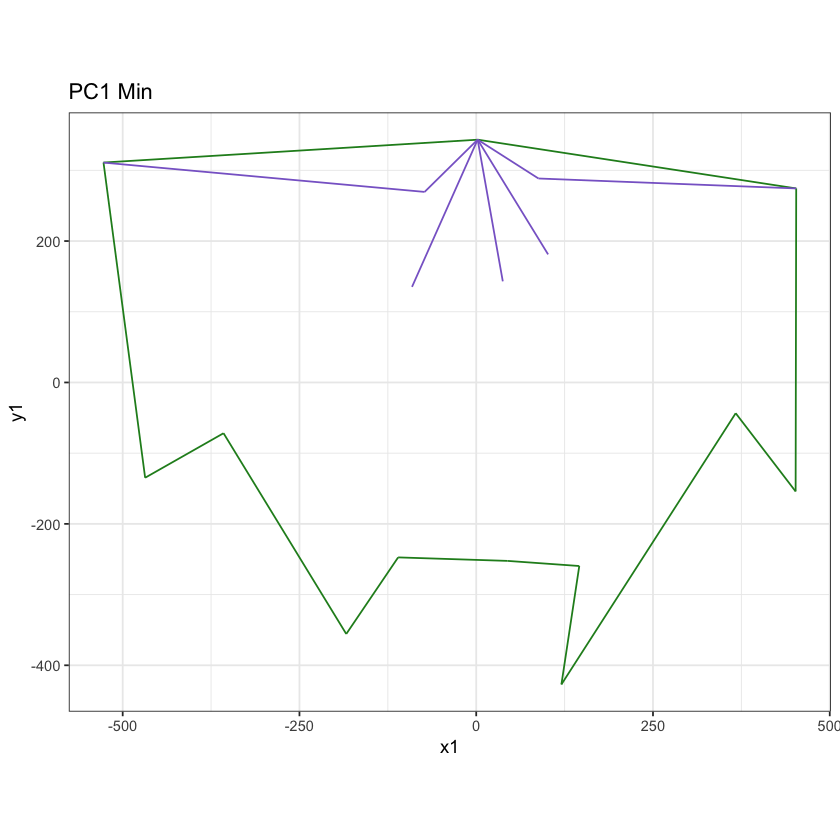

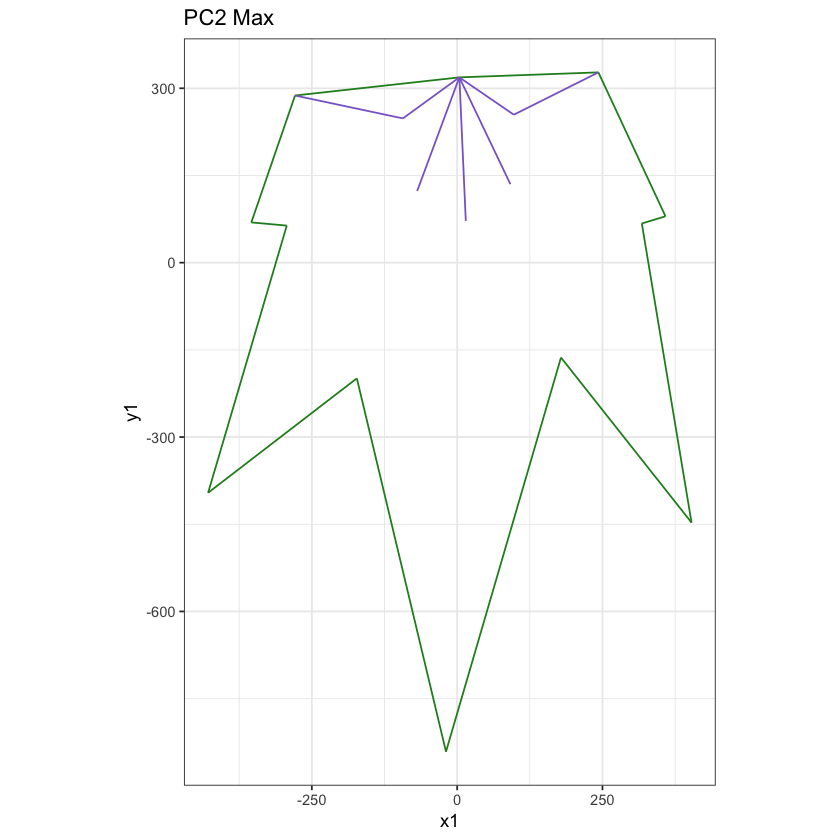

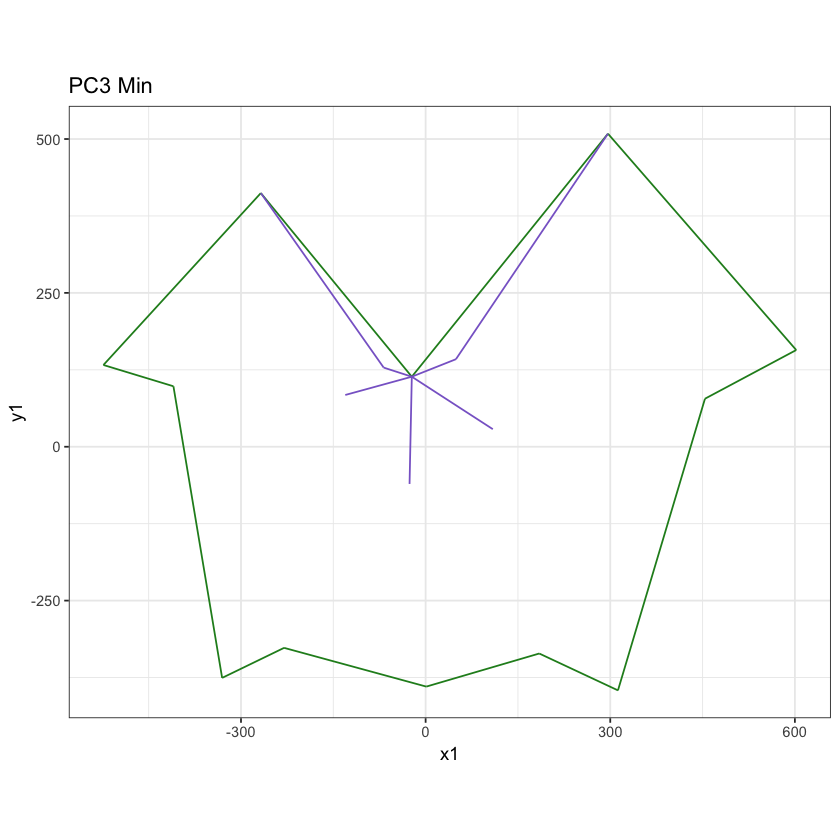

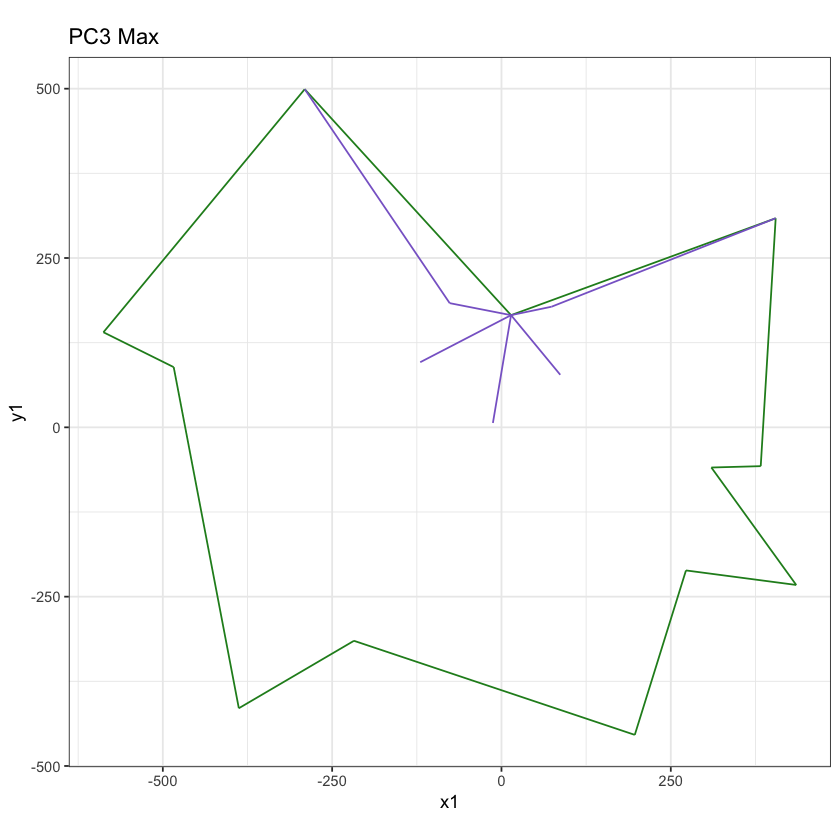

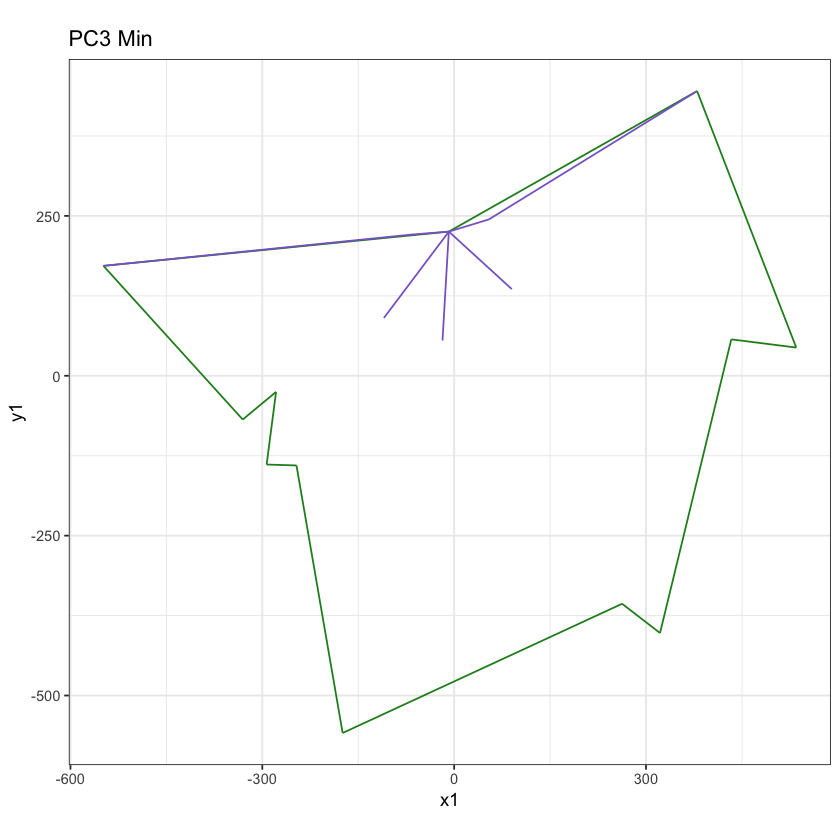

In [19]:
## Here I just did a quick check on PC1-3 to make sure the extremes didn't show anything too crazy

leaf_PC1_max <- as.data.frame(t(morpho_GPA_rotated_flat[morpho_pcs$PC1==max(morpho_pcs$PC1),]))
leaf_PC1_min <- as.data.frame(t(morpho_GPA_rotated_flat[morpho_pcs$PC1==min(morpho_pcs$PC1),]))
leaf_PC2_max <- as.data.frame(t(morpho_GPA_rotated_flat[morpho_pcs$PC2==max(morpho_pcs$PC2),]))
leaf_PC2_min <- as.data.frame(t(morpho_GPA_rotated_flat[morpho_pcs$PC2==min(morpho_pcs$PC2),]))
leaf_PC3_max <- as.data.frame(t(morpho_GPA_rotated_flat[morpho_pcs$PC3==max(morpho_pcs$PC3),]))
leaf_PC3_min <- as.data.frame(t(morpho_GPA_rotated_flat[morpho_pcs$PC3==min(morpho_pcs$PC3),]))

plot_leaf(leaf_PC1_max, title='PC1 Max')
plot_leaf(leaf_PC1_min, title='PC1 Min')
plot_leaf(leaf_PC2_max, title='PC2 Max')
plot_leaf(leaf_PC2_min, title='PC3 Min')
plot_leaf(leaf_PC3_max, title='PC3 Max')
plot_leaf(leaf_PC3_min, title='PC3 Min')


In [20]:
## Add the blocking variable - caution as this replaces the Block column

block_A <- c('8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '10A', '10B', '10C', '10D')
block_B <- c('11A', '11B', '11C', '11D', '12A', '12B', '12C', '12D', '13A', '13B', '13C', '13D')
block_C <- c('14A', '14B', '14C', '14D', '15A', '15B', '15C', '15D', '16A', '16B', '16C', '16D')
block_D <- c('8E', '8F', '8G', '8H', '9E', '9F', '9G', '9H', '10E', '10F', '10G', '10H')
block_E <- c('11E', '11F', '11G', '11H', '12E', '12F', '12G', '12H', '13E', '13F', '13G', '13H')
block_F <- c('14E', '14F', '14G', '14H', '15E', '15F', '15G', '15H', '16E', '16F', '16G', '16H')

new_col <- data.frame(id=paste(morpho_pcs$Row, morpho_pcs$Block, sep=''), Block=rep(NA, length(morpho_pcs$Row)))
new_col$Block <- ifelse(new_col$id %in% block_A, 'A',
                       ifelse(new_col$id %in% block_B, 'B',
                             ifelse(new_col$id %in% block_C, 'C',
                                   ifelse(new_col$id %in% block_D, 'D',
                                         ifelse(new_col$id %in% block_E, 'E',
                                               ifelse(new_col$id %in% block_F, 'F', NA))))))


morpho_pcs$Block <- new_col$Block
table(new_col$Block)


  A   B   C   D   E   F 
409 416 386 418 409 384 

In [21]:
# KIND OF IMPORTANT
morpho_pcs$Leaf_index <- as.factor(morpho_pcs$Leaf_index)
table(morpho_pcs$Leaf_index)


  1   2   3 
793 814 815 

In [22]:
head(morpho_pcs)

PC1        PC2         PC3        PC4        PC5        PC6        PC7       
1  0.9324449 -0.60688084  1.9614914 -0.1984240  0.4691079  1.3861683  0.7242354
2  0.8616283 -0.05925194 -0.5068459  0.9139727  1.0735512  0.9634443  0.3305268
3  1.1542901 -0.96611118  0.8729186  0.2613152  1.0710327  0.6930301  1.2977037
4 -0.8120195  0.09368730 -0.4405114  0.1013432  0.1536768 -0.8598116  0.9382306
5  0.8401290  3.58173733 -0.4418505 -2.5872248 -0.7629798 -0.0239587 -0.4964586
6  1.6039125  1.78872739  0.6220883 -1.4304472  1.6730802 -0.1248603  0.9072166
  PC8         PC9          PC10       ⋯ PC20        indexer Row Block Rep
1  1.13304003  0.572659592 -0.6941878 ⋯  0.62719180 10A1    10  A     1  
2 -0.03026029 -0.243178678 -0.3993828 ⋯ -0.63303042 10A1    10  A     1  
3  0.28158444  0.002601109  0.7589062 ⋯ -0.08054424 10A1    10  A     1  
4  1.39507715 -0.548777316  1.1158324 ⋯  0.47175490 10A1    10  A     1  
5  0.35909591  0.457372828 -0.3505761 ⋯ -1.66701872 10A1    10  A     1  
6  1.47231747 -0.347546676 -0.7759026 ⋯ -3.77696468 10A1    10  A     1  
  Leaf_range Leaf_index Phenology Rootstock Irrigation
1 1_3        2          Harvest   3309C     Full      
2 1_3        1          Harvest   3309C     Full      
3 1_3        3          Harvest   3309C     Full      
4 10_15      2          Veraison  3309C     Full      
5 1_9        1          Veraison  3309C     Full      
6 1_7        1          Anthesis  3309C     Full

In [23]:
rs_c_pal <- c("gray","#1b9e77", "#7570b3", "#e6ab02")
morpho_pcs$Rootstock <- factor(morpho_pcs$Rootstock, levels=c('Own', '1103P', '3309C', 'SO4'), labels=c('Ungrafted', '1103P', '3309C', 'SO4'))

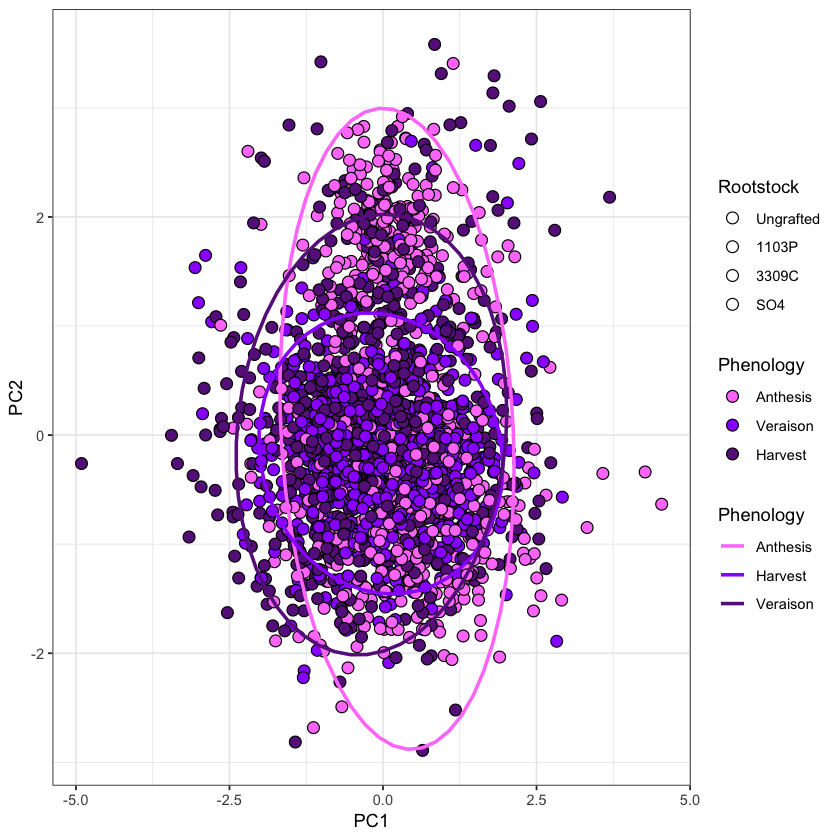

In [24]:
p <- ggplot(morpho_pcs, aes(x=PC1, y=PC2, fill=Phenology)) + 
  geom_point(aes(shape=Rootstock), size=3) +
  stat_ellipse(aes(color=Phenology), linetype=1, size=1, level=0.95) + 
  scale_shape_manual(values=c(21, 21, 21, 21)) +
  scale_color_manual(name='Phenology', values=c('orchid1', 'purple1', 'darkorchid4')) + 
  scale_fill_manual(values=c('orchid1', 'purple1', 'darkorchid4'), labels=c('Anthesis', 'Veraison', 'Harvest')) +
  scale_y_continuous() + 
  guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white"))) + 
  theme_bw()
p

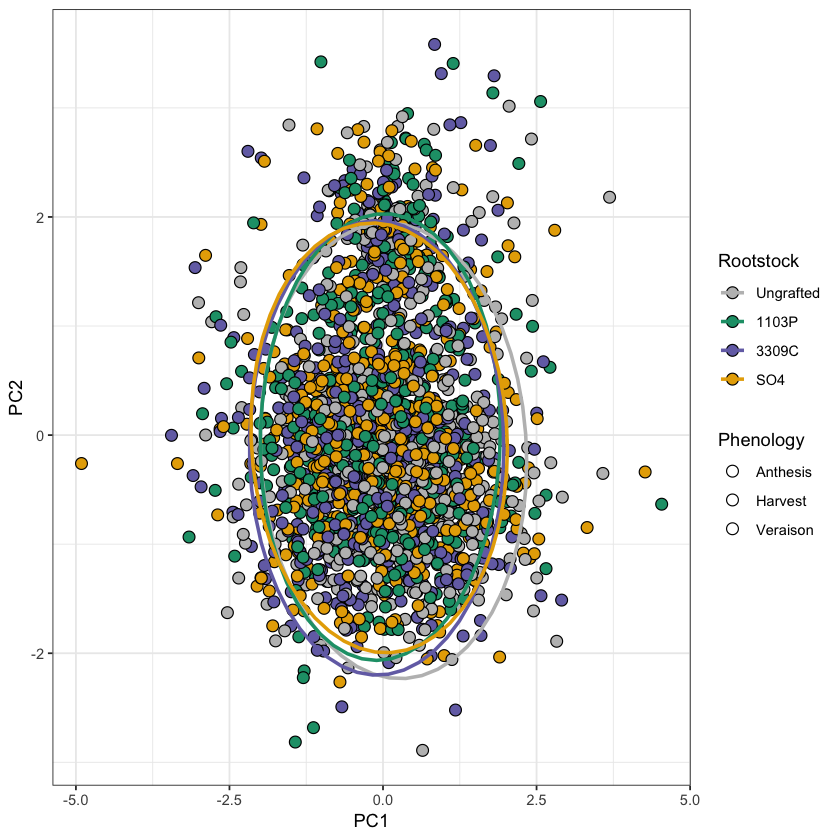

In [25]:
p <- ggplot(morpho_pcs, aes(x=PC1, y=PC2, fill=Rootstock)) + 
  geom_point(aes(shape=Phenology), size=3) +
  stat_ellipse(aes(color=Rootstock), linetype=1, size=1, level=0.95) + 
  scale_shape_manual(values=c(21, 21, 21, 21)) +
  scale_color_manual(name='Rootstock', values=rs_c_pal) + 
  scale_fill_manual(values=rs_c_pal) +
  scale_y_continuous() + 
  guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white"))) + 
  theme_bw()
p

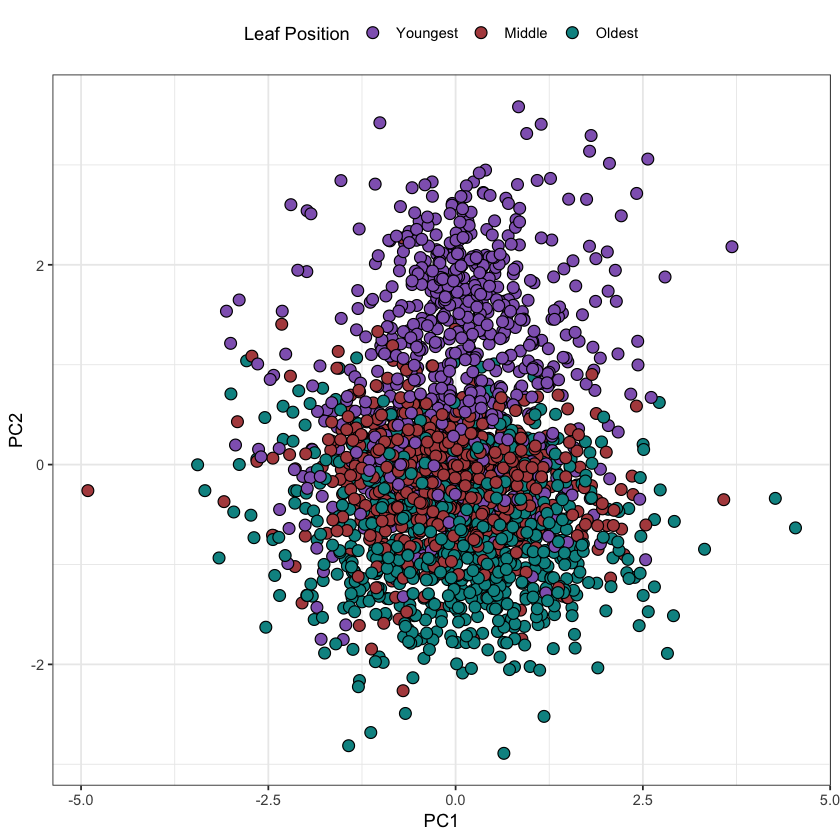

In [26]:
## this got broken somehow? remap colors on edit

xcol <- rgb(145,102,189,maxColorValue=255)
ycol <- rgb(178,76,76,maxColorValue=255)
zcol <- rgb(0,146,146,maxColorValue=255)

morphFig1 <- ggplot(morpho_pcs, aes(x=PC1, y=PC2, fill=as.factor(Leaf_index))) + 
  geom_point(aes(shape=as.factor(Leaf_index)), size=3) +
  #stat_ellipse(aes(color=as.factor(Leaf_index)), linetype=1, size=1, level=0.95) + 
  scale_shape_manual(name='Leaf Position', values=c(21, 21, 21, 21), labels=c('Youngest', 'Middle', 'Oldest')) +
  scale_fill_manual(name='Leaf Position', values=c(xcol, ycol, zcol), labels=c('Youngest', 'Middle', 'Oldest')) +
  scale_y_continuous() + 
  guides(fill = guide_legend(override.aes = list(shape = 21))) +
  theme_bw() + theme(legend.position='top')
morphFig1

### Fit LMs to top 20 PCs

In [27]:
vars <- c('PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
          'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20')

# create a collector for models and anovas
models <- list(rep(0, length(vars)))
anovas <- list(rep(0, length(vars)))

# set the appropriate contrasts for type3 SS

oldc <- getOption("contrasts")
options(contrasts=c('contr.sum','contr.poly'))

pdf('2017_morphology_PC_dist.pdf', onefile=T)
for (idx in 1:length(vars)){
    # get variable name at index
    PC <- vars[idx]
    
    # get data
    d <- morpho_pcs %>% dplyr::select(PC, Block, Leaf_index:Irrigation)
    
    # remove outliers and plot clean data
    d <- anomalize(as_tibble(d), target=PC, method='iqr', alpha=0.03, max_anoms=0.1)
    d <- d[d$anomaly != 'Yes',]
    
    # fit lms
    colnames(d) <- c('PC', 'Block', 'Leaf_index', 'Phenology', 'Rootstock', 'Irrigation')
    #model <- lm(PC ~ Irrigation + Leaf_index + Rootstock + Phenology + Irrigation:Leaf_index + Irrigation:Rootstock + Irrigation:Phenology + Leaf_index:Rootstock + Leaf_index:Phenology + Rootstock:Phenology, data=d, singular.ok=TRUE)
    model <- lm(PC ~ Block + Irrigation + Leaf_index + Rootstock + Phenology + Leaf_index:Rootstock + Leaf_index:Phenology + Rootstock:Phenology, data=d, singular.ok=TRUE)
    models[[idx]] <- model
    
    # compute stats on model under type-3 SS
    stats <- car::Anova(model, type=3)
    anovas[[idx]] <- stats
    
}
dev.off()

# reset base contrasts so nothing is too broken
options(contrasts = oldc)

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(PC)` instead of `PC` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


pdf 
  2

In [28]:
factors <- rownames(anovas[[1]])[2:length(rownames(anovas[[1]]))]

total_var_mat_p=matrix(,length(vars),length(factors)*2)
colnames(total_var_mat_p) <- c(factors, paste(factors, 'p', sep='_'))
rownames(total_var_mat_p) <- vars

for (idx in 1:length(vars)){
    range <- 2:(length(factors)+1)
    SS <- anovas[[idx]]$Sum[range]
    total_var <- sum(SS, na.rm=TRUE)
    var_exp <- SS/total_var * 100
    var_p <- anovas[[idx]]$Pr[range]
    mat_row <- c(var_exp, var_p)
    total_var_mat_p[idx,] <- mat_row
}

head(total_var_mat_p)

Block     Irrigation Leaf_index  Rootstock  Phenology  
PC1 0.5005154 0.16675435  0.33178090 0.94990912  2.63040254
PC2 0.3303755 0.05439024 46.86455278 0.24527491  1.40878430
PC3 0.1924948 0.07158120  0.01833391 0.38435025  0.05039091
PC4 0.1962446 0.14810124  1.89424373 0.03088044  3.40632581
PC5 0.7780651 0.05959463  1.08896660 0.31615853 10.55564183
PC6 1.0980678 0.07000275  0.71007649 0.03729489  7.13432380
    Leaf_index:Rootstock Leaf_index:Phenology Rootstock:Phenology Residuals
PC1 0.39001488            0.6189275           0.17581346          94.23588 
PC2 0.22414381           12.0509117           0.17814731          38.64342 
PC3 0.09542932            0.1234457           0.12361108          98.94036 
PC4 0.29764819            2.5619737           0.28691203          91.17767 
PC5 0.22232163            0.5491176           0.52929638          85.90084 
PC6 0.11922488            1.8168559           0.08369404          88.93046 
    Block_p      Irrigation_p Leaf_index_p Rootstock_p  Phenology_p 
PC1 2.663658e-02 0.1208001    1.497065e-02 2.514967e-05 5.083850e-15
PC2 1.066097e-03 0.1860999    0.000000e+00 1.707897e-03 2.564115e-19
PC3 4.600371e-01 0.4212177    8.013089e-01 2.588267e-02 5.440467e-01
PC4 3.985701e-01 0.1436619    2.108632e-11 8.471153e-01 9.050661e-20
PC5 6.310499e-04 0.4364404    2.880538e-07 3.227904e-02 6.694121e-61
PC6 1.970156e-05 0.3903612    7.427669e-05 8.005947e-01 8.598173e-41
    Leaf_index:Rootstock_p Leaf_index:Phenology_p Rootstock:Phenology_p
PC1 0.12964518              3.512692e-03          0.61462776           
PC2 0.03147503             3.349612e-139          0.08817748           
PC3 0.88941474              5.607440e-01          0.81037322           
PC4 0.25318766              1.379367e-13          0.27555763           
PC5 0.40274898              4.224562e-03          0.02272521           
PC6 0.78257867              7.878385e-10          0.89522426           
    Residuals_p
PC1 NA         
PC2 NA         
PC3 NA         
PC4 NA         
PC5 NA         
PC6 NA

In [29]:
total_var_mat_p <- data.frame(total_var_mat_p)

total_var_mat_p$variable <- rownames(total_var_mat_p)
total_var_mat_p$Residuals <- NULL
total_var_mat_p$Residuals_p <- NULL

head(total_var_mat_p)

write.csv(total_var_mat_p, file='2017_morphology_var_p.csv', quote=F)

Block     Irrigation Leaf_index  Rootstock  Phenology  
PC1 0.5005154 0.16675435  0.33178090 0.94990912  2.63040254
PC2 0.3303755 0.05439024 46.86455278 0.24527491  1.40878430
PC3 0.1924948 0.07158120  0.01833391 0.38435025  0.05039091
PC4 0.1962446 0.14810124  1.89424373 0.03088044  3.40632581
PC5 0.7780651 0.05959463  1.08896660 0.31615853 10.55564183
PC6 1.0980678 0.07000275  0.71007649 0.03729489  7.13432380
    Leaf_index.Rootstock Leaf_index.Phenology Rootstock.Phenology Block_p     
PC1 0.39001488            0.6189275           0.17581346          2.663658e-02
PC2 0.22414381           12.0509117           0.17814731          1.066097e-03
PC3 0.09542932            0.1234457           0.12361108          4.600371e-01
PC4 0.29764819            2.5619737           0.28691203          3.985701e-01
PC5 0.22232163            0.5491176           0.52929638          6.310499e-04
PC6 0.11922488            1.8168559           0.08369404          1.970156e-05
    Irrigation_p Leaf_index_p Rootstock_p  Phenology_p  Leaf_index.Rootstock_p
PC1 0.1208001    1.497065e-02 2.514967e-05 5.083850e-15 0.12964518            
PC2 0.1860999    0.000000e+00 1.707897e-03 2.564115e-19 0.03147503            
PC3 0.4212177    8.013089e-01 2.588267e-02 5.440467e-01 0.88941474            
PC4 0.1436619    2.108632e-11 8.471153e-01 9.050661e-20 0.25318766            
PC5 0.4364404    2.880538e-07 3.227904e-02 6.694121e-61 0.40274898            
PC6 0.3903612    7.427669e-05 8.005947e-01 8.598173e-41 0.78257867            
    Leaf_index.Phenology_p Rootstock.Phenology_p variable
PC1  3.512692e-03          0.61462776            PC1     
PC2 3.349612e-139          0.08817748            PC2     
PC3  5.607440e-01          0.81037322            PC3     
PC4  1.379367e-13          0.27555763            PC4     
PC5  4.224562e-03          0.02272521            PC5     
PC6  7.878385e-10          0.89522426            PC6

variable factor var      
1 PC01     Block  0.5005154
2 PC02     Block  0.3303755
3 PC03     Block  0.1924948
4 PC04     Block  0.1962446
5 PC05     Block  0.7780651
6 PC06     Block  1.0980678

pdf 
  2

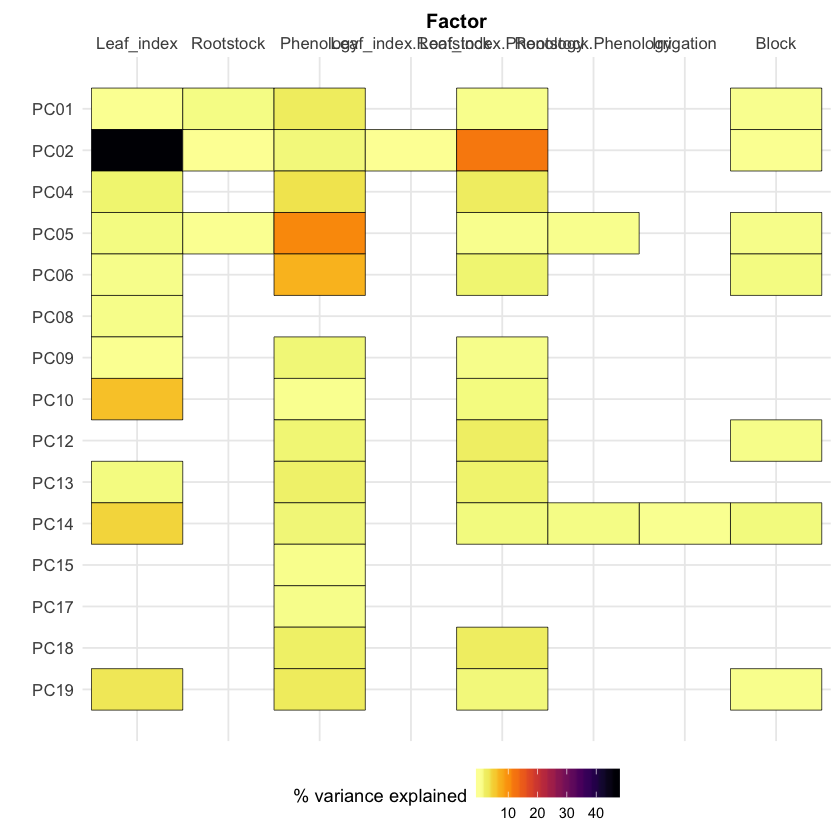

In [30]:
total_var_mat_p$variable <- c('PC01', 'PC02', 'PC03', 'PC04', 'PC05', 'PC06', 'PC07', 'PC08', 'PC09', 'PC10',
                               'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20')

# Get variance columns
total_var <- total_var_mat_p %>% dplyr::select(variable, Block:Rootstock.Phenology)

# reorganize and rename to format for plotting
total_var <- total_var %>% gather(key=factor, value=var, -variable)

total_var <- total_var %>% mutate(factor=str_replace(factor, "_var" %R% END, ""))
head(total_var)

#get p-value columns
total_p <- total_var_mat_p %>% dplyr::select(Block_p:Rootstock.Phenology_p)
total_p <- data.frame(t(apply(total_p, 1, FUN=p.adjust, method='fdr')))
total_p$variable <- total_var_mat_p$variable

#reorganize and rename to format for plotting
total_p <- total_p %>% gather(key=factor, value=p_value, -variable)
total_p <- total_p %>% mutate(factor=str_replace(factor,"_p" %R% END, ""))

#join variance and p-value tables back together 
total_var_p <- full_join(total_var, total_p,by=c("variable", "factor"))

#elements need a number for y-axis when plotting, there are 20 elements here 
total_var_p <- total_var_p %>% arrange(variable) %>% mutate(var_number=rep(1:20, each=8))

#only plot significant p_values
total_var_p_sig <- total_var_p %>% filter(p_value < 0.05) 
write.table(total_var_p_sig[,c("variable", "factor","var", "p_value")], "2017_morphology_var_p_sig.txt", sep="\t", row.names=F, quote=F, col.names=T)

var_number_fix <- rep(0, dim(total_var_p_sig)[1])
unique_variable_names <- unique(total_var_p_sig$variable)
for (idx in 1:length(var_number_fix)){
    var_number_fix[idx] <- which(unique_variable_names == total_var_p_sig$variable[[idx]])
}

total_var_p_sig$var_number <- var_number_fix
total_var_p_sig$factor <- factor(total_var_p_sig$factor, levels=c('Leaf_index', 'Rootstock', 'Phenology', 'Leaf_index.Rootstock', 'Leaf_index.Phenology', 'Rootstock.Phenology', 'Irrigation', 'Block'))
# total_var_p_sig$variable <- factor(total_var_p_sig$variable, levels=c('PC1', 'PC2','PC3','PC4','PC5','PC6','PC7',
#                                                                       'PC8','PC9','PC10', 'PC11', 'PC12', 'PC13', 
#                                                                       'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20'))
# total_var_p_sig$var_number <- factor(total_var_p_sig$var_number, levels=c('1', '8', '9', '10', '11','12','13', '2','3','4','5','6','7'))


#make plot
t <- ggplot(data=total_var_p_sig, aes(x=factor, y=as.numeric(as.character(var_number)), fill=var)) + 
    geom_tile(color="black", size=0.2)+
    theme_minimal() +
    labs(x = "Factor", y="") + 
    theme(axis.text=element_text(size=10),axis.title=element_text(size=12,face="bold"),legend.position = "bottom") +
    scale_y_continuous(trans="reverse", breaks = 1:length(unique(total_var_p_sig$variable)), minor_breaks=NULL, labels=unique(total_var_p_sig[,"variable"])) +
    scale_x_discrete(position = "top") + 
    scale_fill_viridis(option="inferno", name="% variance explained", direction = -1)
t

pdf("morphology_variance_heatmap_black_viridis.pdf", width=12, height=4)
  t
dev.off()

### Post-hocs on interesting results

Here, I run post hocs for the results highlighted in the manuscript. 

In [40]:
## PC1

# rootstock
p.val.max <- 0.05/7

module.emm <- emmeans::emmeans(models[[1]], ~Rootstock)
res <- as.data.frame(pairs(module.emm))
res <- res[res$p.val < p.val.max,]
res

#Leaf Position by Phenology
p.val.max <- 0.05/7

module.emm <- emmeans::emmeans(models[[1]], ~Leaf_index:Phenology)
res <- as.data.frame(pairs(module.emm))
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = " ", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = " ", names = c('na', 'i2', 'p2')))    
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res <- res[res$c1.i1 == res$c2.i2,] %>% dplyr::select(contrast:p.value)
res$p.adj <- p.adjust(res$p.value, method='fdr')
res <- res[res$p.adj < p.val.max,]
res

NOTE: Results may be misleading due to involvement in interactions


contrast          estimate  SE         df   t.ratio  p.value     
1 Ungrafted - 1103P 0.1970131 0.05689424 2391 3.462795 3.052873e-03
2 Ungrafted - 3309C 0.2566493 0.05657015 2391 4.536834 3.547962e-05
3 Ungrafted - SO4   0.2111464 0.05622461 2391 3.755408 1.016886e-03

contrast                estimate  SE         df   t.ratio  p.value     
14 2 Anthesis - 2 Veraison 0.4011134 0.08542668 2391 4.695412 9.784014e-05
18 3 Anthesis - 3 Harvest  0.4161368 0.08505745 2391 4.892421 3.732574e-05
21 3 Anthesis - 3 Veraison 0.6414543 0.08542149 2391 7.509284 0.000000e+00
   p.adj       
14 0.0002935204
18 0.0001679658
21 0.0000000000

In [46]:
## PC 2

## Rootstock by Phenology
module.emm <- emmeans::emmeans(models[[2]], ~Rootstock:Phenology)
res <- as.data.frame(pairs(module.emm))
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = " ", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = " ", names = c('na', 'i2', 'p2')))    
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res$c2.i2 <- trimws(res$c2.i2, which='left')
res <- res[res$c1.p1 == res$c2.p2,] %>% dplyr::select(contrast:p.value)
res$p.adj <- p.adjust(res$p.value, method='fdr')
res <- res[res$p.adj < p.val.max,]
res

# Leaf position by Phenology

module.emm <- emmeans::emmeans(models[[2]], ~Leaf_index:Phenology)
res <- as.data.frame(pairs(module.emm))
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = " ", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = " ", names = c('na', 'i2', 'p2')))    
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res <- res[res$c1.i1 == res$c2.i2,] %>% dplyr::select(contrast:p.value)
res$p.adj <- p.adjust(res$p.value, method='fdr')
res <- res[res$p.adj < p.val.max,]
res

contrast estimate SE df t.ratio p.value p.adj

contrast                estimate   SE         df   t.ratio    p.value     
3  1 Anthesis - 1 Harvest   1.4887161 0.05620414 2391  26.487659 0.000000e+00
6  1 Anthesis - 1 Veraison  0.7021971 0.05697733 2391  12.324148 0.000000e+00
18 3 Anthesis - 3 Harvest  -0.5721974 0.05549487 2391 -10.310815 0.000000e+00
21 3 Anthesis - 3 Veraison -0.3929288 0.05573239 2391  -7.050277 2.907785e-11
24 1 Harvest - 1 Veraison  -0.7865190 0.05389214 2391 -14.594318 0.000000e+00
   p.adj       
3  0.000000e+00
6  0.000000e+00
18 0.000000e+00
21 5.234013e-11
24 0.000000e+00

In [47]:
## PC4

# Leaf position by Phenology

module.emm <- emmeans::emmeans(models[[4]], ~Leaf_index:Phenology)
res <- as.data.frame(pairs(module.emm))
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = " ", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = " ", names = c('na' ,'i2', 'p2')))    
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res <- res[res$c1.i1 == res$c2.i2,] %>% dplyr::select(contrast:p.value)
res$p.adj <- p.adjust(res$p.value, method='fdr')
res <- res[res$p.adj < p.val.max,]
res

contrast                estimate   SE         df   t.ratio   p.value     
3  1 Anthesis - 1 Harvest  -0.5345862 0.08485454 2391 -6.300031 1.263653e-08
18 3 Anthesis - 3 Harvest  -0.8365131 0.08378371 2391 -9.984197 0.000000e+00
21 3 Anthesis - 3 Veraison -0.3670751 0.08414230 2391 -4.362551 4.554287e-04
33 3 Harvest - 3 Veraison   0.4694380 0.08051312 2391  5.830577 2.246900e-07
   p.adj       
3  5.686438e-08
18 0.000000e+00
21 1.024715e-03
33 6.740701e-07

In [48]:
## PC5 

## Rootstock by Phenology
module.emm <- emmeans::emmeans(models[[5]], ~Rootstock:Phenology)
res <- as.data.frame(pairs(module.emm))
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = " ", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = " ", names = c('na', 'i2', 'p2')))    
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res$c2.i2 <- trimws(res$c2.i2, which='left')
res <- res[res$c1.p1 == res$c2.p2,] %>% dplyr::select(contrast:p.value)
res$p.adj <- p.adjust(res$p.value, method='fdr')
res <- res[res$p.adj < p.val.max,]
res

# Leaf position by Phenology
module.emm <- emmeans::emmeans(models[[5]], ~Leaf_index:Phenology)
res <- as.data.frame(pairs(module.emm))
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = " ", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = " ", names = c('na', 'i2', 'p2')))    
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res <- res[res$c1.i1 == res$c2.i2,] %>% dplyr::select(contrast:p.value)
res$p.adj <- p.adjust(res$p.value, method='fdr')
res <- res[res$p.adj < p.val.max,]
res

contrast estimate SE df t.ratio p.value p.adj

contrast                estimate   SE         df   t.ratio   p.value     
3  1 Anthesis - 1 Harvest  -0.7545766 0.08214553 2391 -9.185851 0.000000e+00
11 2 Anthesis - 2 Harvest  -0.8111791 0.08117570 2391 -9.992881 0.000000e+00
14 2 Anthesis - 2 Veraison -0.4920442 0.08146099 2391 -6.040243 6.382597e-08
18 3 Anthesis - 3 Harvest  -0.7903423 0.08110889 2391 -9.744213 0.000000e+00
24 1 Harvest - 1 Veraison   0.6638890 0.07876640 2391  8.428580 0.000000e+00
29 2 Harvest - 2 Veraison   0.3191349 0.07801093 2391  4.090901 1.465084e-03
33 3 Harvest - 3 Veraison   0.5610479 0.07794272 2391  7.198208 0.000000e+00
   p.adj       
3  0.000000e+00
11 0.000000e+00
14 9.573896e-08
18 0.000000e+00
24 0.000000e+00
29 1.883679e-03
33 0.000000e+00

In [49]:
## PC6

# Leaf position by Phenology
module.emm <- emmeans::emmeans(models[[5]], ~Leaf_index:Phenology)
res <- as.data.frame(pairs(module.emm))
res <- transform(res, comps=reshape::colsplit(contrast, split = "-", names = c('c1', 'c2')))
res <- transform(res, c1=reshape::colsplit(comps.c1, split = " ", names = c('i1', 'p1')))
res <- transform(res, c2=reshape::colsplit(comps.c2, split = " ", names = c('na', 'i2', 'p2')))    
res$c2.p2 <- trimws(res$c2.p2, which='left')
res$c1.p1 <- trimws(res$c1.p1, which='right')
res <- res[res$c1.i1 == res$c2.i2,] %>% dplyr::select(contrast:p.value)
res$p.adj <- p.adjust(res$p.value, method='fdr')
res <- res[res$p.adj < p.val.max,]
res

contrast                estimate   SE         df   t.ratio   p.value     
3  1 Anthesis - 1 Harvest  -0.7545766 0.08214553 2391 -9.185851 0.000000e+00
11 2 Anthesis - 2 Harvest  -0.8111791 0.08117570 2391 -9.992881 0.000000e+00
14 2 Anthesis - 2 Veraison -0.4920442 0.08146099 2391 -6.040243 6.382597e-08
18 3 Anthesis - 3 Harvest  -0.7903423 0.08110889 2391 -9.744213 0.000000e+00
24 1 Harvest - 1 Veraison   0.6638890 0.07876640 2391  8.428580 0.000000e+00
29 2 Harvest - 2 Veraison   0.3191349 0.07801093 2391  4.090901 1.465084e-03
33 3 Harvest - 3 Veraison   0.5610479 0.07794272 2391  7.198208 0.000000e+00
   p.adj       
3  0.000000e+00
11 0.000000e+00
14 9.573896e-08
18 0.000000e+00
24 0.000000e+00
29 1.883679e-03
33 0.000000e+00

## Random Forests

Can a random forest predict any of the following: Rootstock, Phenology, Leaf Position, interactions of the above?

In [38]:
dim(morpho_GPA_rotated_flat)

[1] 2422   34

In [39]:
set.seed(1992)

# Get random 80% training/ 20% test indices
shuf_idx <- sample(1:nrow(morpho_GPA_rotated_flat))
n <- ceiling(length(shuf_idx) * 0.8)
train_idx <- shuf_idx[1:n]
test_idx <- shuf_idx[(n+1):nrow(morpho_GPA_rotated_flat)]

# grab the indices from the flattened GPA rotated data
X_train <- morpho_GPA_rotated_flat[train_idx, ]
X_test <- morpho_GPA_rotated_flat[test_idx,]

In [40]:
# fit Random Forest for Rootstock

# get train test labels
labels <- morpho_pcs$Rootstock
y_train <- labels[train_idx]
y_test <- labels[test_idx]

rsMorphGrid <- expand.grid(mtry=(seq(2, 34, 2)))
rsMorphrf <- train(x=X_train, y=y_train, method='rf', tuneGrid=rsMorphGrid, ntree=100, keep.forest=T, importance=1)

Random Forest 

1938 samples
  34 predictor
   4 classes: 'Ungrafted', '1103P', '3309C', 'SO4' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1938, 1938, 1938, 1938, 1938, 1938, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa     
   2    0.2622183  0.01881658
   4    0.2681348  0.02618182
   6    0.2696445  0.02828884
   8    0.2624689  0.01877185
  10    0.2600439  0.01547862
  12    0.2597242  0.01508645
  14    0.2618395  0.01781776
  16    0.2647534  0.02155682
  18    0.2650481  0.02220908
  20    0.2595128  0.01492778
  22    0.2662959  0.02369814
  24    0.2611426  0.01702336
  26    0.2627967  0.01895616
  28    0.2600421  0.01552471
  30    0.2636830  0.02033121
  32    0.2604826  0.01607799
  34    0.2662442  0.02371390

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 6.

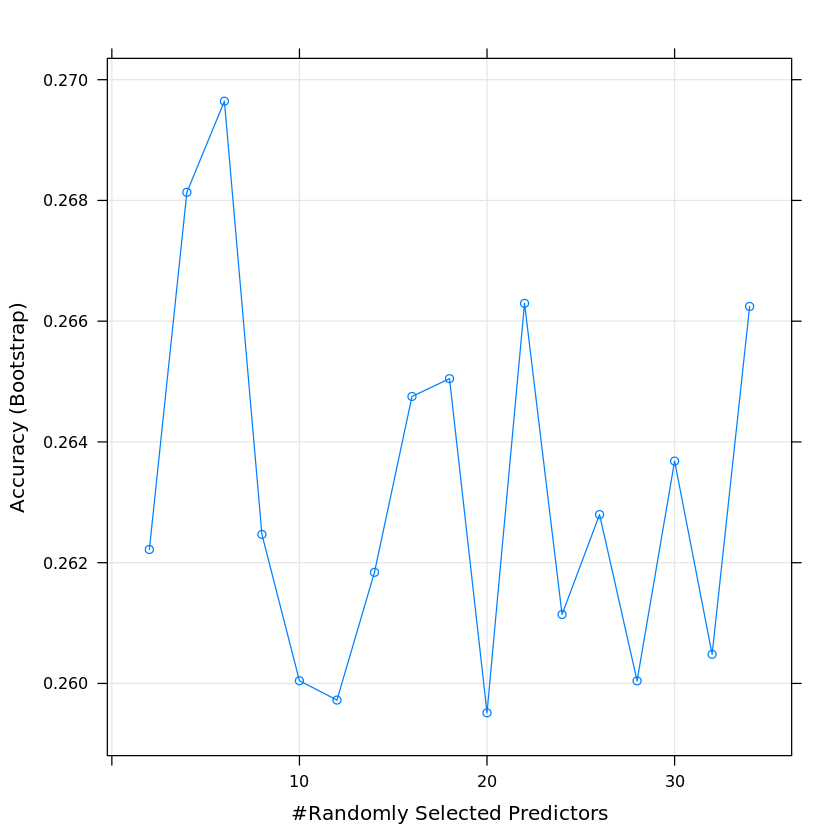

In [41]:
rsMorphrf
plot(rsMorphrf)

Ungrafted X1103P X3309C SO4 MeanDecreaseAccuracy MeanDecreaseGini

Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
please use list() instead

  # Before:
  funs(name = f(.))

  # After: 
  list(name = ~ f(.))
This warning is displayed once per session.”

png 
  2

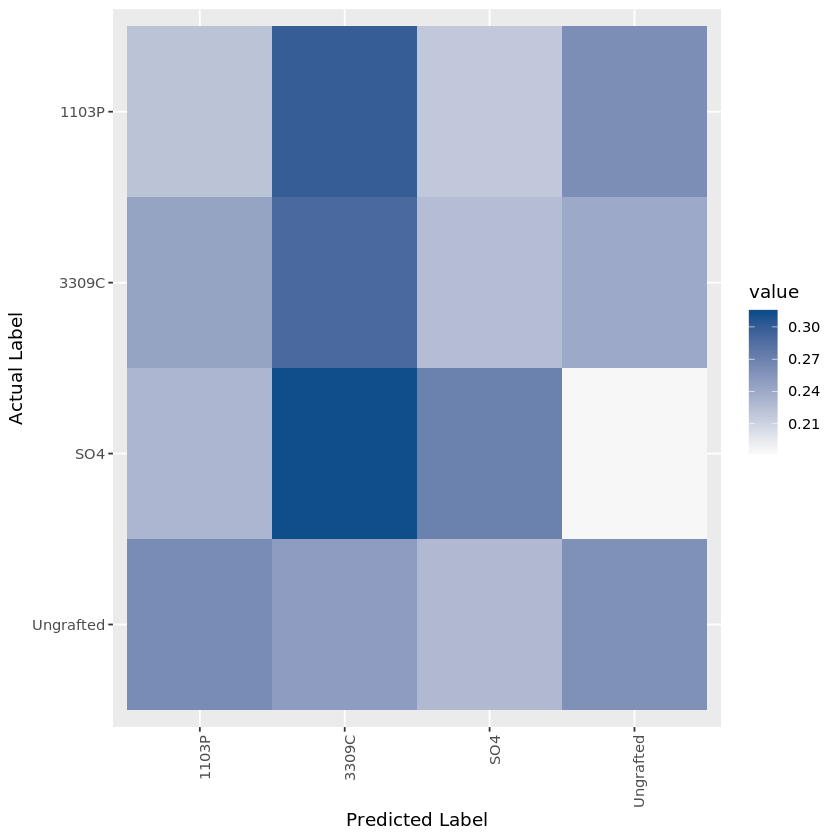

In [42]:
d <- rsMorphrf$finalModel
important_features <- data.frame(d$importance)
write.csv(important_features, file='2017_morphology_rootstockImportFeatures.csv', quote=F)
important_features[important_features$MeanDecreaseAccuracy > 0.03,]

d <- data.frame(d$confusion) %>% dplyr::select(-class.error)
drn <- rownames(d)
drs <- rowSums(d)

d <- d %>% mutate_if(is.numeric, funs(./drs))
d$y <- factor(drn)
d <- d %>% gather(x, value, Ungrafted:SO4)

p <- ggplot(d, aes(x=x, y=rev(y), fill=value)) +
     geom_tile() + 
     scale_fill_gradient(low='grey97', high='dodgerblue4') + 
     theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
     labs(x='Predicted Label', y='Actual Label') +  
     scale_x_discrete(labels=c('1103P', '3309C', 'SO4', 'Ungrafted')) + 
     scale_y_discrete(labels=rev(c('1103P', '3309C', 'SO4', 'Ungrafted')))

p 

pdf('2017_morphology_RFconfmat_rootstock.pdf')
  p
dev.off()

In [43]:
y_pred <- predict(rsMorphrf, X_test)
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

           Reference
Prediction  Ungrafted 1103P 3309C SO4
  Ungrafted        37    29    25  31
  1103P            20    27    38  23
  3309C            22    31    37  45
  SO4              23    30    34  32

Overall Statistics
                                          
               Accuracy : 0.2748          
                 95% CI : (0.2355, 0.3169)
    No Information Rate : 0.2769          
    P-Value [Acc > NIR] : 0.5576          
                                          
                  Kappa : 0.032           
                                          
 Mcnemar's Test P-Value : 0.4016          

Statistics by Class:

                     Class: Ungrafted Class: 1103P Class: 3309C Class: SO4
Sensitivity                   0.36275      0.23077      0.27612    0.24427
Specificity                   0.77749      0.77929      0.72000    0.75354
Pos Pred Value                0.30328      0.25000      0.27407    0.26891
Neg Pred Value            

Random Forest 

1938 samples
  34 predictor
   3 classes: 'Anthesis', 'Veraison', 'Harvest' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1938, 1938, 1938, 1938, 1938, 1938, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.6059218  0.4080098
   4    0.6088538  0.4127446
   6    0.6070492  0.4100713
   8    0.6074700  0.4104127
  10    0.6110809  0.4158496
  12    0.6065590  0.4092100
  14    0.6064338  0.4088650
  16    0.6069763  0.4099050
  18    0.6056722  0.4077684
  20    0.6027321  0.4033796
  22    0.6055172  0.4076019
  24    0.5965924  0.3941343
  26    0.5966724  0.3941037
  28    0.5987957  0.3974277
  30    0.5939938  0.3901175
  32    0.5980578  0.3962646
  34    0.5923332  0.3875682

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 10.

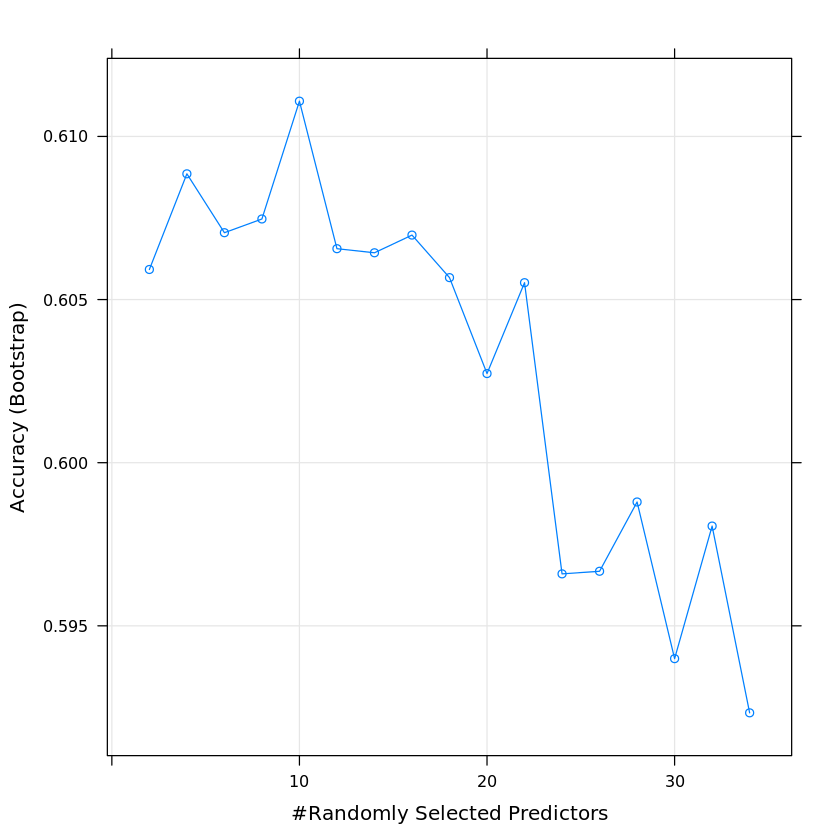

In [44]:
# fit Random Forest for Phenology

# get train test labels
labels <- morpho_pcs$Phenology
labels <- factor(labels, levels=c('Anthesis', 'Veraison', 'Harvest'))
y_train <- labels[train_idx]
y_test <- labels[test_idx]


pMorphGrid <- expand.grid(mtry=(seq(2, 34, 2)))
pMorphrf <- train(x=X_train, y=y_train, method='rf', tuneGrid=pMorphGrid, ntree=100, keep.forest=T, importance=1)

pMorphrf
plot(pMorphrf)

Anthesis Veraison Harvest MeanDecreaseAccuracy MeanDecreaseGini

png 
  2

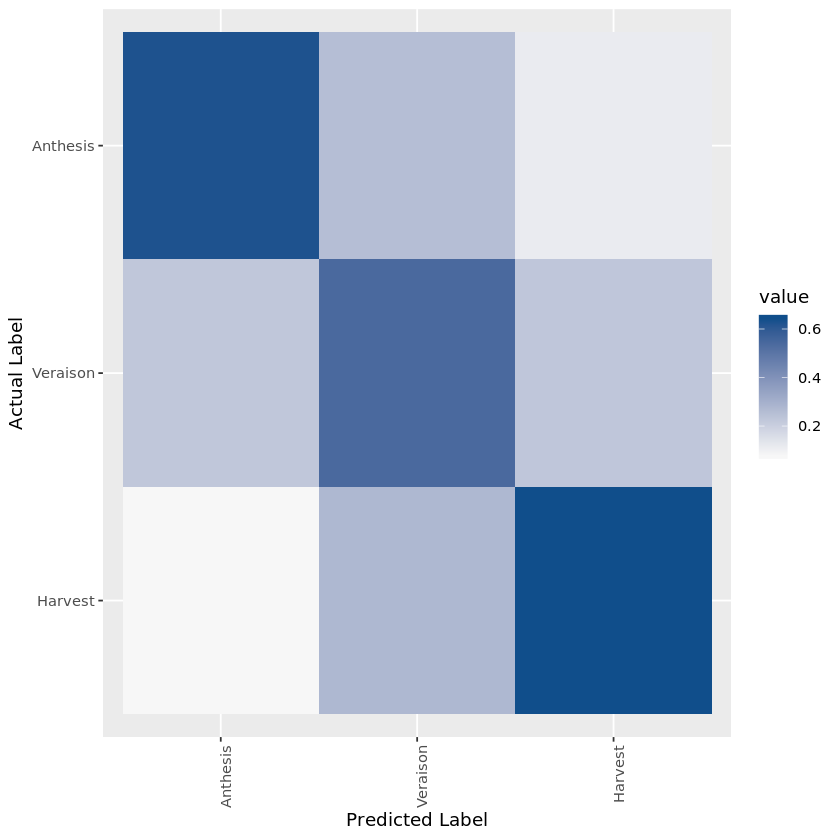

In [45]:
d <- pMorphrf$finalModel
important_features <- data.frame(d$importance)
write.csv(important_features, file='2017_morphology_phenologyImportFeatures.csv', quote=F)
important_features[important_features$MeanDecreaseAccuracy > 0.05,]

d <- data.frame(d$confusion) %>% dplyr::select(-class.error)
drn <- rownames(d)
drs <- rowSums(d)

d <- d %>% mutate_if(is.numeric, funs(./drs))
d$y <- factor(drn, levels=c('Anthesis', 'Veraison', 'Harvest'))
d <- d %>% gather(x, value, Anthesis:Harvest)
d$x <- factor(d$x, levels=c('Anthesis', 'Veraison', 'Harvest'))

p <- ggplot(d, aes(x=x, y=rev(y), fill=value)) +
     geom_tile() + 
     scale_fill_gradient(low='grey97', high='dodgerblue4') + 
     theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
     labs(x='Predicted Label', y='Actual Label') + 
     scale_x_discrete(labels=c('Anthesis', 'Veraison', 'Harvest')) + 
     scale_y_discrete(labels=c('Harvest', 'Veraison', 'Anthesis'))

p

pdf('2017_morphology_RFconfmat_phenology.pdf')
  p
dev.off()

In [46]:
y_pred <- predict(pMorphrf, X_test)
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

          Reference
Prediction Anthesis Veraison Harvest
  Anthesis       84       39      12
  Veraison       37      100      37
  Harvest         9       42     124

Overall Statistics
                                          
               Accuracy : 0.6364          
                 95% CI : (0.5917, 0.6793)
    No Information Rate : 0.374           
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.4502          
                                          
 Mcnemar's Test P-Value : 0.85            

Statistics by Class:

                     Class: Anthesis Class: Veraison Class: Harvest
Sensitivity                   0.6462          0.5525         0.7168
Specificity                   0.8559          0.7558         0.8360
Pos Pred Value                0.6222          0.5747         0.7086
Neg Pred Value                0.8682          0.7387         0.8414
Prevalence                   

Random Forest 

1938 samples
  34 predictor
   3 classes: '1', '2', '3' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1938, 1938, 1938, 1938, 1938, 1938, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.6800303  0.5198965
   4    0.6820561  0.5228412
   6    0.6829143  0.5240920
   8    0.6804101  0.5203371
  10    0.6803243  0.5202136
  12    0.6819446  0.5226186
  14    0.6769378  0.5150579
  16    0.6753763  0.5127638
  18    0.6737291  0.5102843
  20    0.6752326  0.5125051
  22    0.6765026  0.5144132
  24    0.6737437  0.5102778
  26    0.6719722  0.5076529
  28    0.6719001  0.5075276
  30    0.6693604  0.5037077
  32    0.6728579  0.5089511
  34    0.6691196  0.5033731

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 6.

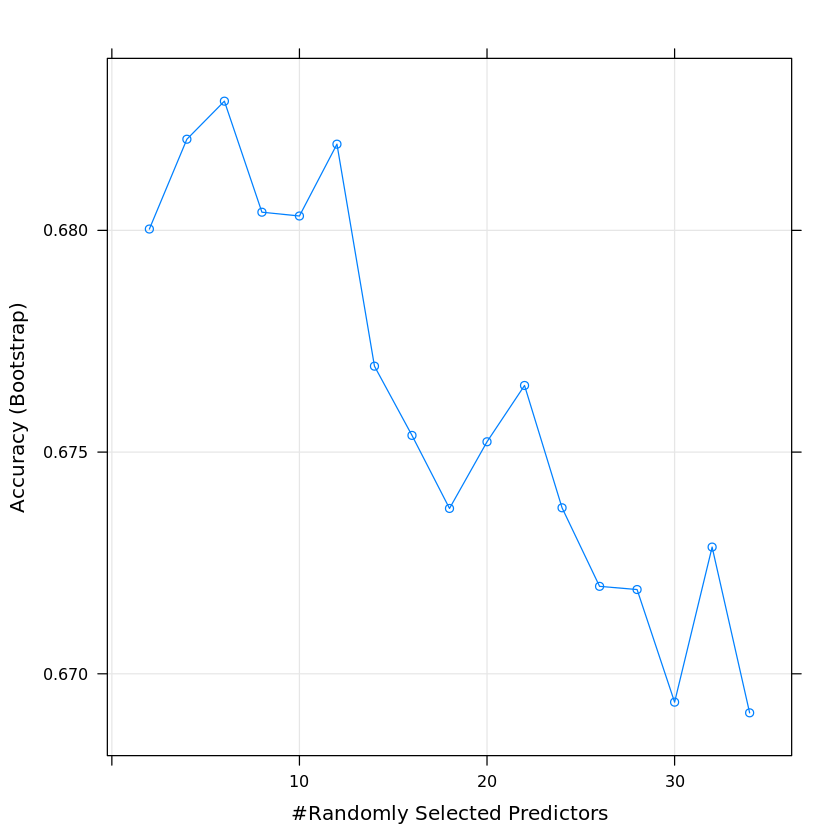

In [47]:
# fit Random Forest for Leaf_index

# get train test labels
labels <- morpho_pcs$Leaf_index
labels <- factor(labels, levels=c('1', '2', '3'))
y_train <- labels[train_idx]
y_test <- labels[test_idx]


lpMorphGrid <- expand.grid(mtry=(seq(2, 34, 2)))
lpMorphrf <- train(x=X_train, y=y_train, method='rf', tuneGrid=lpMorphGrid, ntree=100, keep.forest=T, importance=1)

lpMorphrf
plot(lpMorphrf)

X1 X2 X3 MeanDecreaseAccuracy MeanDecreaseGini

png 
  2

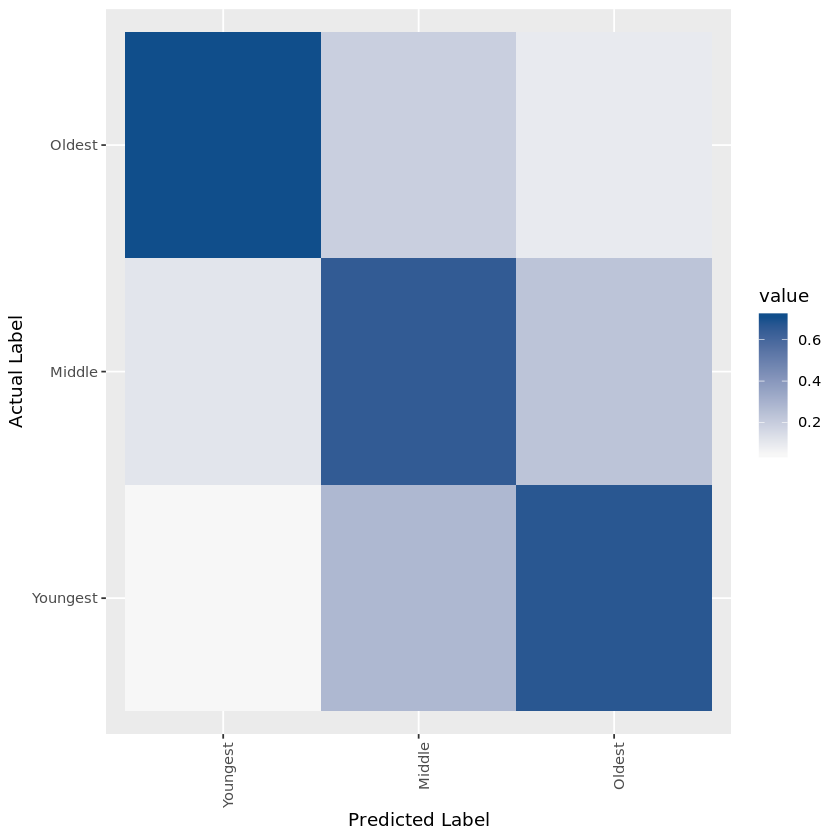

In [48]:
d <- lpMorphrf$finalModel
important_features <- data.frame(d$importance)
write.csv(important_features, file='2017_morphology_leafIndexImportFeatures.csv', quote=F)
important_features[important_features$MeanDecreaseAccuracy > 0.5,]


d <- data.frame(d$confusion) %>% dplyr::select(-class.error)
drn <- rownames(d)
drs <- rowSums(d)

d <- d %>% mutate_if(is.numeric, funs(./drs))
d$y <- factor(drn, levels=c('1', '2', '3'))
d <- d %>% gather(x, value, X1:X3)
d$x <- factor(d$x, levels=c('X1', 'X2', 'X3'))

p <- ggplot(d, aes(x=x, y=rev(y), fill=value)) +
     geom_tile() + 
     scale_fill_gradient(low='grey97', high='dodgerblue4') + 
     theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
     labs(x='Predicted Label', y='Actual Label') + 
     scale_x_discrete(labels=c('Youngest', 'Middle', 'Oldest')) + 
     scale_y_discrete(labels=c('Youngest', 'Middle', 'Oldest'))

p

pdf('2017_morphology_RFconfmat_leafIndex.pdf')
  p
dev.off()

In [49]:
y_pred <- predict(lpMorphrf, X_test)
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3
         1 128  19   9
         2  29 103  29
         3  12  35 120

Overall Statistics
                                          
               Accuracy : 0.7252          
                 95% CI : (0.6831, 0.7645)
    No Information Rate : 0.3492          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.588           
                                          
 Mcnemar's Test P-Value : 0.3803          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.7574   0.6561   0.7595
Specificity            0.9111   0.8226   0.8558
Pos Pred Value         0.8205   0.6398   0.7186
Neg Pred Value         0.8750   0.8328   0.8801
Prevalence             0.3492   0.3244   0.3264
Detection Rate         0.2645   0.2128   0.2479
Detection Prevalence   0.3223   0.3326   0.3450
Balanced Accuracy      0.8343   0.7393   

Random Forest 

1938 samples
  34 predictor
  12 classes: 'Anthesis_Ungrafted', 'Anthesis_1103P', 'Anthesis_3309C', 'Anthesis_SO4', 'Veraison_Ungrafted', 'Veraison_1103P', 'Veraison_3309C', 'Veraison_SO4', 'Harvest_Ungrafted', 'Harvest_1103P', 'Harvest_3309C', 'Harvest_SO4' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1938, 1938, 1938, 1938, 1938, 1938, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa     
   2    0.1565887  0.08075749
   4    0.1590147  0.08334027
   6    0.1574656  0.08165445
   8    0.1592801  0.08357661
  10    0.1574295  0.08159186
  12    0.1571151  0.08116806
  14    0.1543888  0.07835564
  16    0.1564891  0.08047698
  18    0.1556111  0.07961513
  20    0.1550102  0.07883142
  22    0.1559806  0.07992523
  24    0.1536814  0.07739065
  26    0.1553840  0.07930246
  28    0.1526015  0.07621177
  30    0.1516846  0.07533929
  32    0.1510337  0.07453062
  34    0.1515424  0.07486912

Accuracy was use

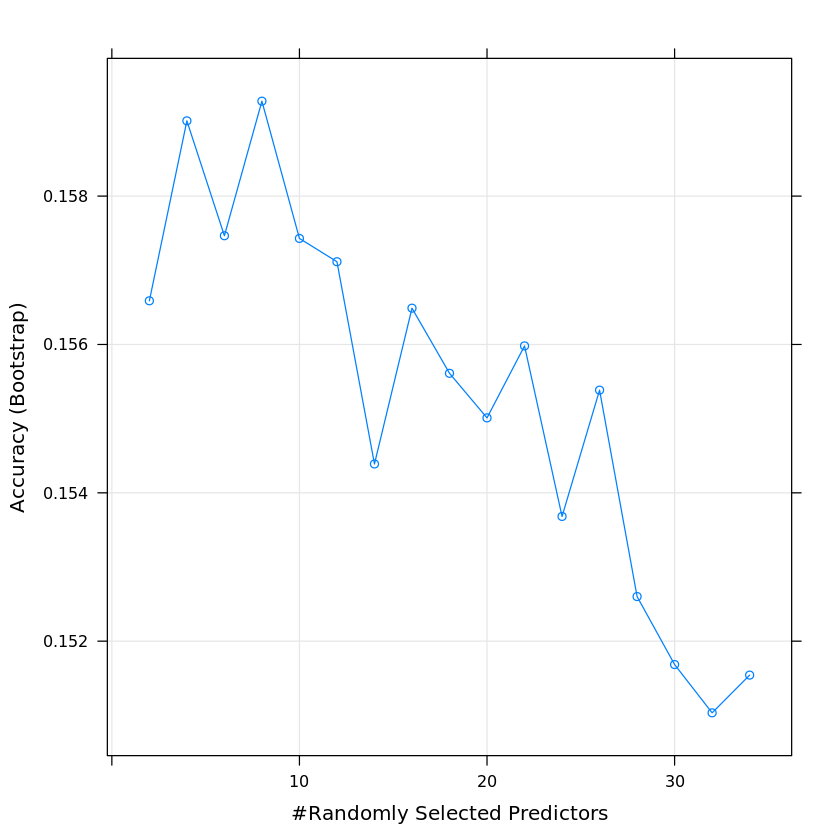

In [50]:
# fit Random Forest for Rootstock X Phenology

# get train test labels
labels <- as.factor(paste(morpho_pcs$Phenology, morpho_pcs$Rootstock, sep='_'))
label_levels <- c('Anthesis_Ungrafted', 'Anthesis_1103P', 'Anthesis_3309C', 'Anthesis_SO4',
                  'Veraison_Ungrafted', 'Veraison_1103P', 'Veraison_3309C', 'Veraison_SO4',
                  'Harvest_Ungrafted', 'Harvest_1103P','Harvest_3309C','Harvest_SO4')

labels <- factor(labels, levels=label_levels)


y_train <- labels[train_idx]
y_test <- labels[test_idx]

rpMorphGrid <- expand.grid(mtry=(seq(2, 34, 2)))
rpMorphrf <- train(x=X_train, y=y_train, method='rf', tuneGrid=rpMorphGrid, ntree=100, keep.forest=T, importance=1)

rpMorphrf
plot(rpMorphrf)

png 
  2

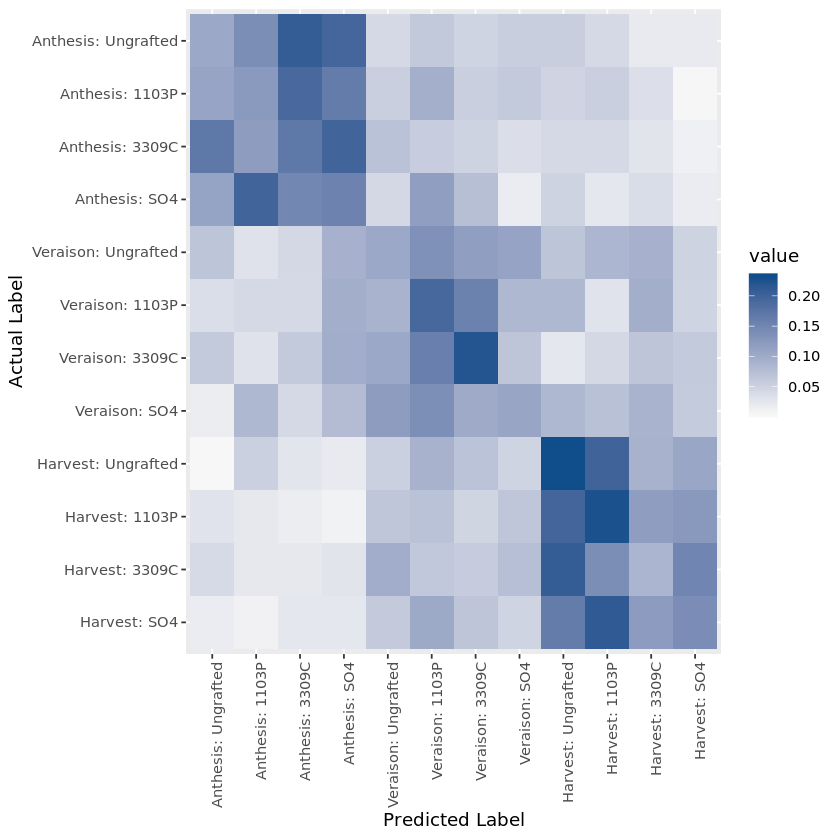

In [51]:
d <- rpMorphrf$finalModel
important_features <- data.frame(d$importance)
write.csv(important_features, file='2017_morphology_rootstockPhenologyImportFeatures.csv', quote=F)

d <- data.frame(d$confusion) %>% dplyr::select(-class.error)
drn <- rownames(d)
drs <- rowSums(d)

d <- d %>% mutate_if(is.numeric, funs(./drs))
d$y <- factor(drn, levels=label_levels)
d <- d %>% gather(x, value, Anthesis_Ungrafted:Harvest_SO4)
d$x <- factor(d$x, levels=label_levels)

p <- ggplot(d, aes(x=x, y=rev(y), fill=value)) +
     geom_tile() + 
     scale_fill_gradient(low='grey97', high='dodgerblue4') + 
     theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
     labs(x='Predicted Label', y='Actual Label') + 
     scale_x_discrete(labels=c("Anthesis: Ungrafted", "Anthesis: 1103P", "Anthesis: 3309C", "Anthesis: SO4",
                               "Veraison: Ungrafted", "Veraison: 1103P", "Veraison: 3309C", "Veraison: SO4",
                               "Harvest: Ungrafted", "Harvest: 1103P", "Harvest: 3309C", "Harvest: SO4")) + 
     scale_y_discrete(labels=rev(c("Anthesis: Ungrafted", "Anthesis: 1103P", "Anthesis: 3309C", "Anthesis: SO4",
                               "Veraison: Ungrafted", "Veraison: 1103P", "Veraison: 3309C", "Veraison: SO4",
                               "Harvest: Ungrafted", "Harvest: 1103P", "Harvest: 3309C", "Harvest: SO4")))

p

pdf('2017_morphology_RFconfmat_phenologyRootstock.pdf')
  p 
dev.off()

In [52]:
y_pred <- predict(rpMorphrf, X_test)
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

                    Reference
Prediction           Anthesis_Ungrafted Anthesis_1103P Anthesis_3309C
  Anthesis_Ungrafted                  6              5              5
  Anthesis_1103P                      6              3              5
  Anthesis_3309C                      8              4              9
  Anthesis_SO4                        3              6              8
  Veraison_Ungrafted                  2              1              1
  Veraison_1103P                      1              0              3
  Veraison_3309C                      1              1              2
  Veraison_SO4                        0              2              2
  Harvest_Ungrafted                   3              1              1
  Harvest_1103P                       1              0              0
  Harvest_3309C                       2              2              1
  Harvest_SO4                         0              2              0
                    Referen

In [53]:
# fit Random Forest for Phenology X Leaf Index

# get train test labels
labels <- as.factor(paste(morpho_pcs$Phenology, morpho_pcs$Leaf_index, sep='_'))
labels <- factor(labels, levels=c('Anthesis_1', 'Anthesis_2', 'Anthesis_3',
                                  'Veraison_1', 'Veraison_2', 'Veraison_3',
                                  'Harvest_1', 'Harvest_2', 'Harvest_3'))
y_train <- labels[train_idx]
y_test <- labels[test_idx]


plpMorphGrid <- expand.grid(mtry=(seq(2, 34, 2)))
plpMorphrf <- train(x=X_train, y=y_train, method='rf', tuneGrid=plpMorphGrid, ntree=100, keep.forest=T, importance=1)

Random Forest 

1938 samples
  34 predictor
   9 classes: 'Anthesis_1', 'Anthesis_2', 'Anthesis_3', 'Veraison_1', 'Veraison_2', 'Veraison_3', 'Harvest_1', 'Harvest_2', 'Harvest_3' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1938, 1938, 1938, 1938, 1938, 1938, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.4248488  0.3533806
   4    0.4317587  0.3610282
   6    0.4335336  0.3629187
   8    0.4312420  0.3603840
  10    0.4334541  0.3627354
  12    0.4341661  0.3634553
  14    0.4318230  0.3609365
  16    0.4327189  0.3618144
  18    0.4272448  0.3556227
  20    0.4277753  0.3562682
  22    0.4233662  0.3512901
  24    0.4238265  0.3517594
  26    0.4211287  0.3486935
  28    0.4208684  0.3483824
  30    0.4194927  0.3468695
  32    0.4164378  0.3433914
  34    0.4149517  0.3417774

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 12.

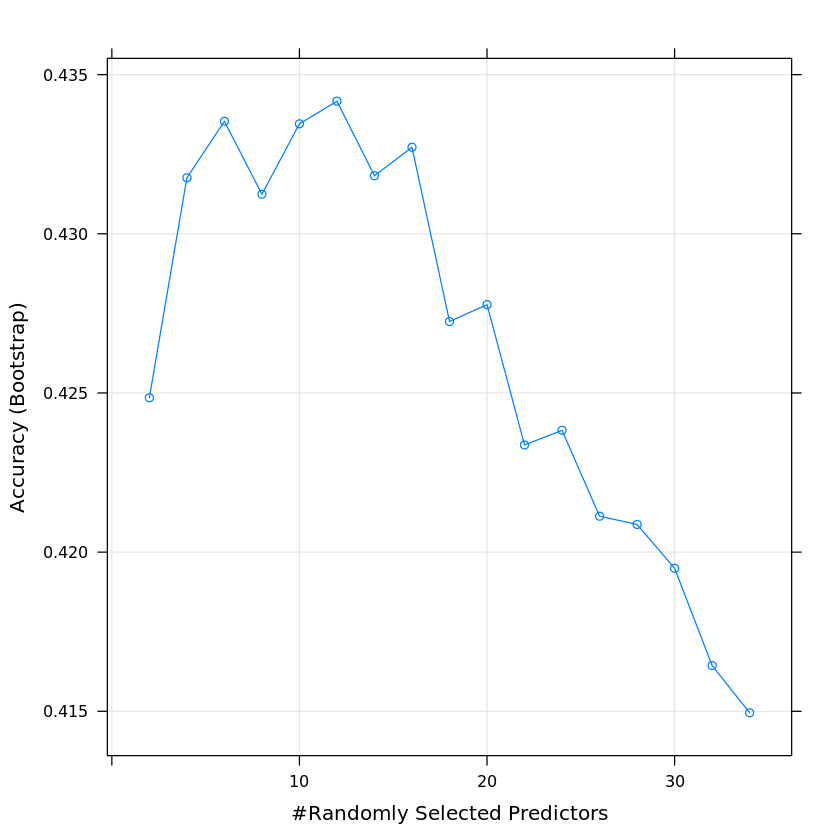

In [54]:
plpMorphrf
plot(plpMorphrf)

png 
  2

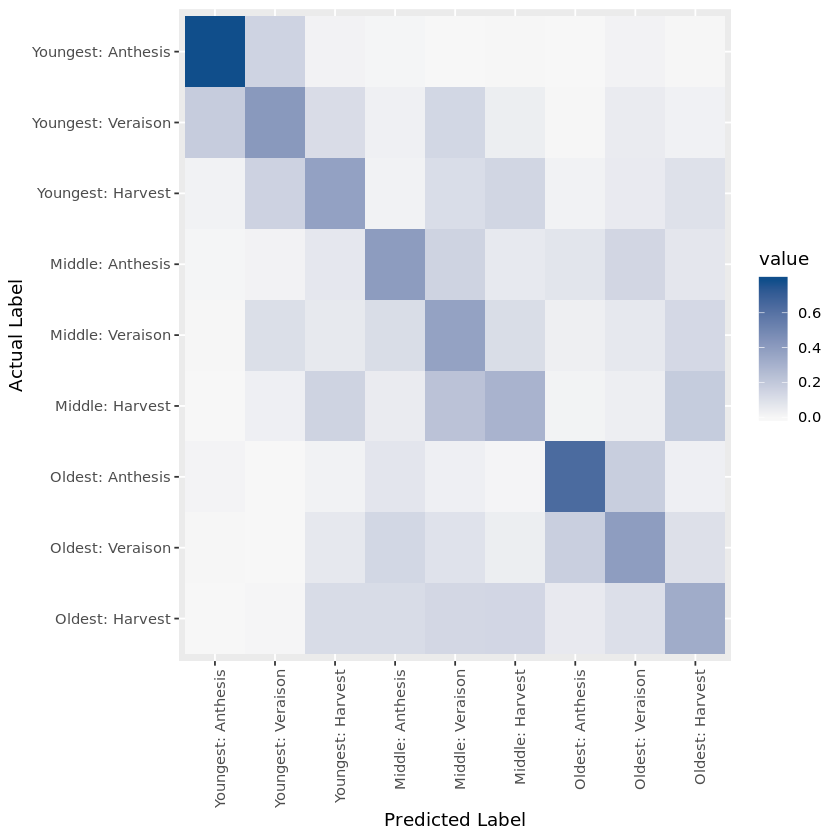

In [55]:
d <- plpMorphrf$finalModel
important_features <- data.frame(d$importance)
write.csv(important_features, file='2017_morphology_phenologyLeafIndexImportFeatures.csv', quote=F)


d <- data.frame(d$confusion) %>% dplyr::select(-class.error)
drn <- rownames(d)
drs <- rowSums(d)

plot_factors <- c('Anthesis_1', 'Veraison_1', 'Harvest_1',
                  'Anthesis_2', 'Veraison_2', 'Harvest_2',
                  'Anthesis_3', 'Veraison_3', 'Harvest_3')

d <- d %>% mutate_if(is.numeric, funs(./drs))
d$y <- factor(drn, levels=plot_factors)
d <- d %>% gather(x, value, Anthesis_1:Harvest_3)
d$x <- factor(d$x, levels=c(plot_factors))


p <- ggplot(d, aes(x=x, y=rev(y), fill=value)) +
     geom_tile() + 
     scale_fill_gradient(low='grey97', high='dodgerblue4') + 
     theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
     labs(x='Predicted Label', y='Actual Label') + 
     scale_x_discrete(labels=c('Youngest: Anthesis', 'Youngest: Veraison', 'Youngest: Harvest',
                                  'Middle: Anthesis', 'Middle: Veraison', 'Middle: Harvest',
                                  'Oldest: Anthesis', 'Oldest: Veraison', 'Oldest: Harvest')) + 
     scale_y_discrete(labels=rev(c('Youngest: Anthesis', 'Youngest: Veraison', 'Youngest: Harvest',
                                   'Middle: Anthesis', 'Middle: Veraison', 'Middle: Harvest',
                                   'Oldest: Anthesis', 'Oldest: Veraison', 'Oldest: Harvest')))

p

pdf('2017_morphology_RFconfmat_phenologyLeafIndex.pdf')
  p 
dev.off()

In [56]:
y_pred <- predict(plpMorphrf, X_test)
caret::confusionMatrix(y_pred, y_test)

Confusion Matrix and Statistics

            Reference
Prediction   Anthesis_1 Anthesis_2 Anthesis_3 Veraison_1 Veraison_2 Veraison_3
  Anthesis_1         28          2          0         16          2          0
  Anthesis_2          0         17          3          3          9          7
  Anthesis_3          0          2         36          0          2          8
  Veraison_1          8          1          0         23          3          1
  Veraison_2          1          8          2         13         16          4
  Veraison_3          0          6         13          2          4         24
  Harvest_1           0          0          0         10          3          4
  Harvest_2           0          0          0          1          9          0
  Harvest_3           0          1          2          2          5         10
            Reference
Prediction   Harvest_1 Harvest_2 Harvest_3
  Anthesis_1         3         0         1
  Anthesis_2         1         2         2
  An

Warning message in lda.default(x, grouping, ...):
“variables are collinear”

pdf 
  2

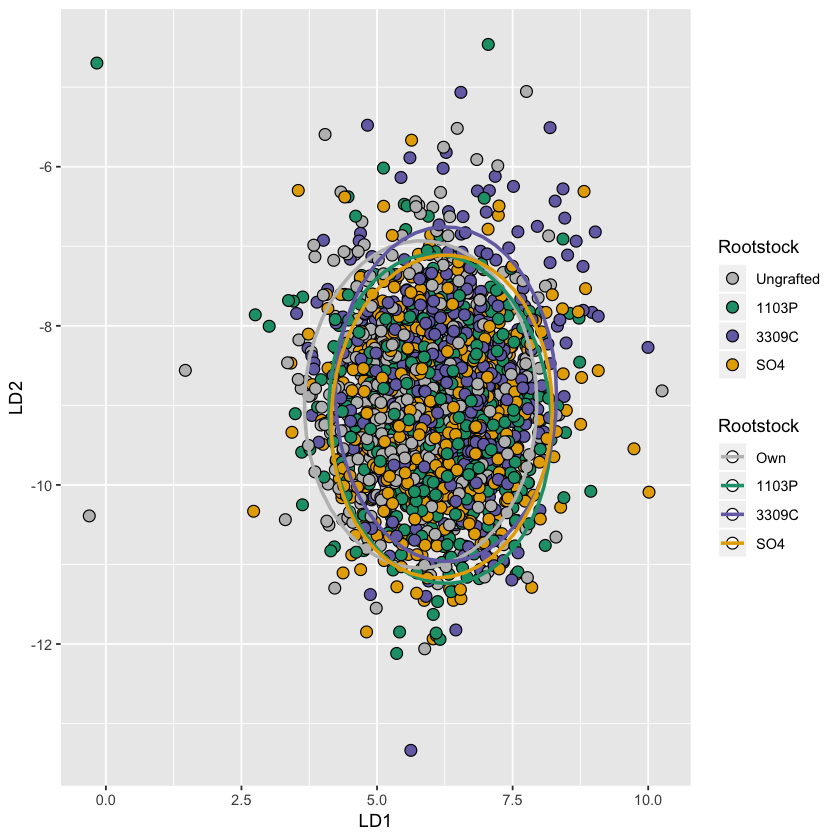

pdf 
  2

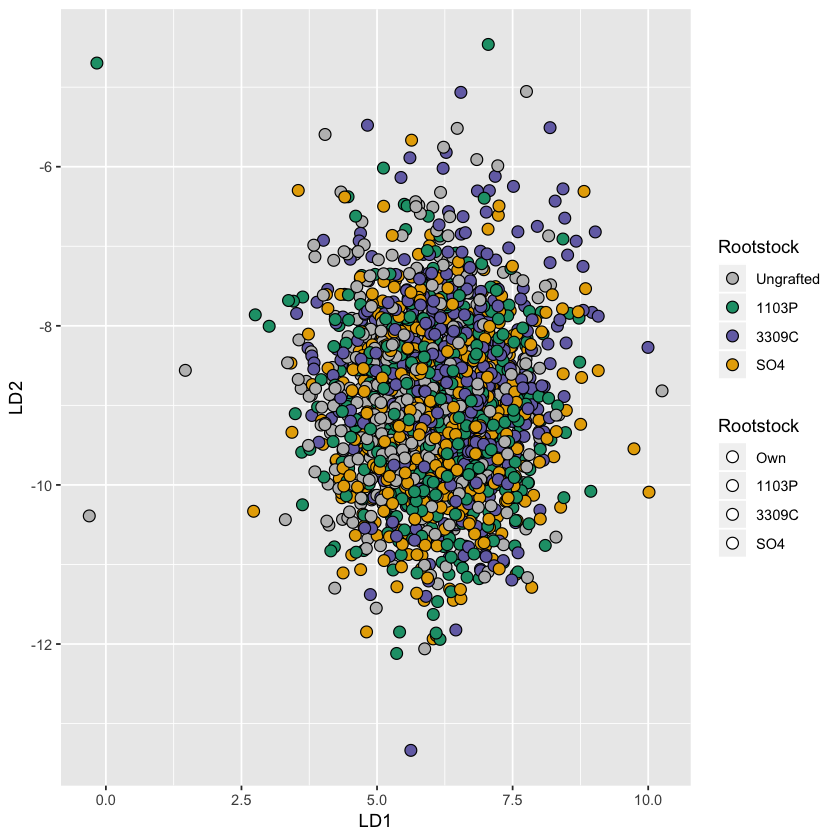

In [51]:
dot <- function(x, y){
    return(x %*% y)
}

rs_c_pal <- c("gray","#1b9e77", "#7570b3", "#e6ab02")

d <- morpho_GPA_rotated_flat
y <- morpho_meta$Rootstock
y <- factor(y, levels=c('Own', '1103P', '3309C', 'SO4'))
lda <- lda(d,y)
lda.scale <- data.frame(lda$scaling)

lda.plot <- data.frame(LD1=apply(d, 1, dot, y=lda.scale$LD1), LD2=apply(d, 1, dot, y=lda.scale$LD2))
lda.plot$Rootstock <- y

p <- ggplot(lda.plot, aes(x=LD1, y=LD2, fill=Rootstock)) + 
  geom_point(aes(shape=Rootstock), size=3) +
  stat_ellipse(aes(color=Rootstock), linetype=1, size=1, level=0.95) + 
  scale_shape_manual(values=c(21, 21, 21, 21)) +
  scale_color_manual(name='Rootstock', values=rs_c_pal) + 
  scale_fill_manual(name='Rootstock', values=rs_c_pal, labels=c('Ungrafted', '1103P', '3309C', 'SO4')) +
  scale_y_continuous() +
  guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white")))

p

pdf('2017_morphology_LDA_rootstock.pdf')
  p
dev.off()


p <- ggplot(lda.plot, aes(x=LD1, y=LD2, fill=Rootstock)) + 
  geom_point(aes(shape=Rootstock), size=3) +
  #stat_ellipse(aes(color=rootstock), linetype=1, size=1, level=0.95) + 
  scale_shape_manual(values=c(21, 21, 21, 21)) +
  scale_color_manual(name='Rootstock', values=rs_c_pal) + 
  scale_fill_manual(name='Rootstock', values=rs_c_pal, labels=c('Ungrafted', '1103P', '3309C', 'SO4')) +
  scale_y_continuous() + 
  guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white")))

p

pdf('2017_morphology_LDA_rootstock_noEllipses.pdf')
  p
dev.off()

Warning message in lda.default(x, grouping, ...):
“variables are collinear”

pdf 
  2

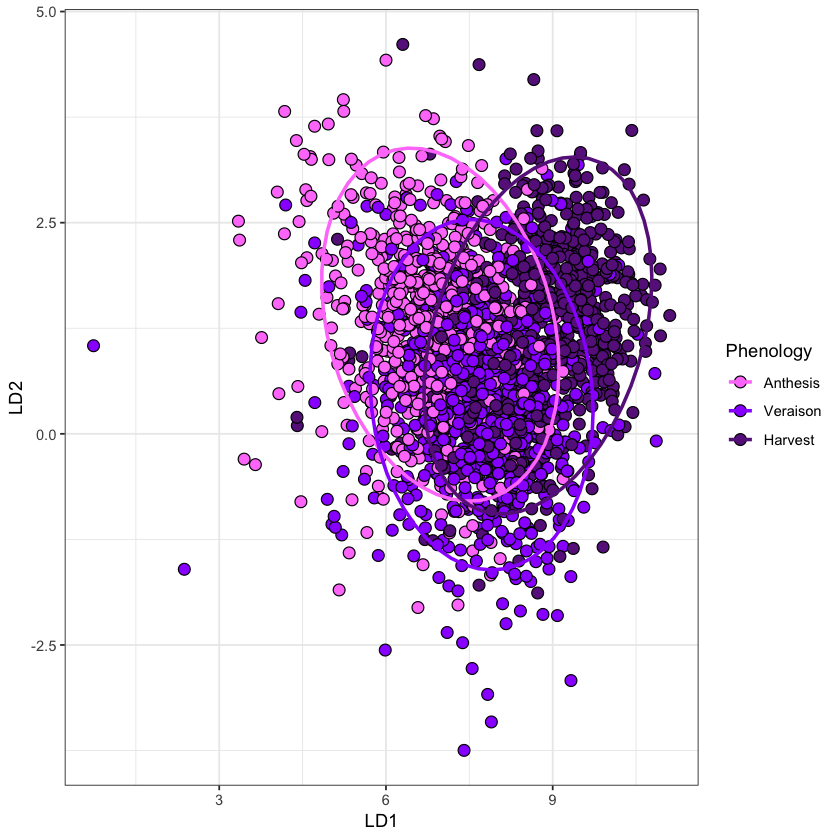

pdf 
  2

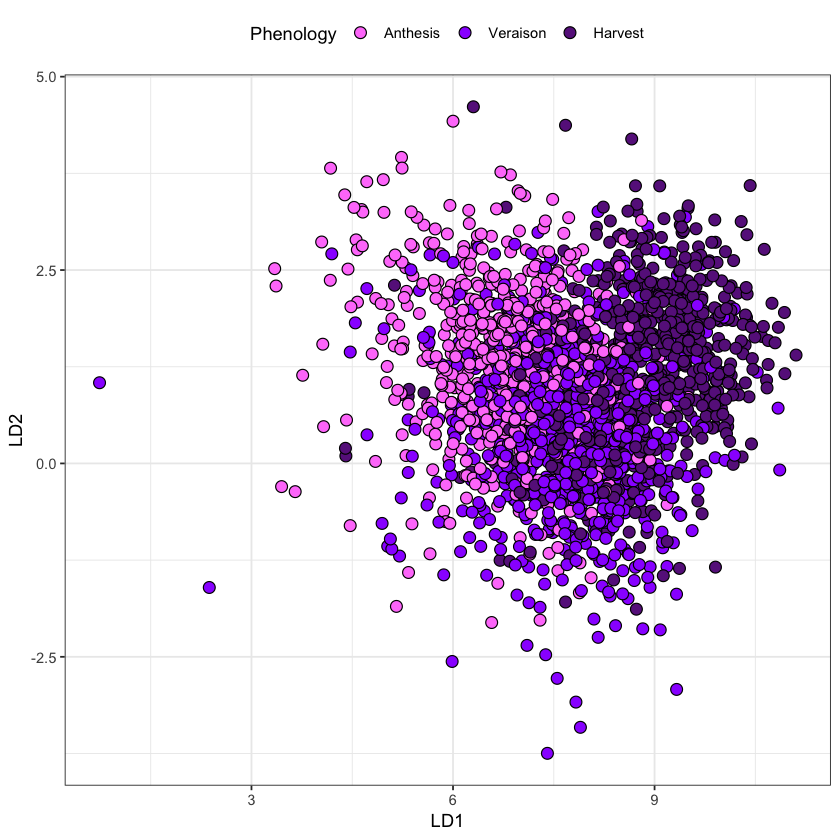

In [52]:
d <- morpho_GPA_rotated_flat
y <- morpho_meta$Phenology
y <- factor(y, levels=c('Anthesis', 'Veraison', 'Harvest'))

lda <- lda(d,y)
lda.scale <- data.frame(lda$scaling)

lda.plot <- data.frame(LD1=apply(d, 1, dot, y=lda.scale$LD1), LD2=apply(d, 1, dot, y=lda.scale$LD2))
lda.plot$Phenology <- y

morphFig2 <- ggplot(lda.plot, aes(x=LD1, y=LD2, fill=Phenology)) + 
  geom_point(aes(shape=Phenology), size=3) +
  stat_ellipse(aes(color=Phenology), linetype=1, size=1, level=0.95) + 
  scale_shape_manual(values=c(21, 21, 21, 21)) +
  scale_fill_manual(values=c('orchid1', 'purple1', 'darkorchid4'), labels=c('Anthesis', 'Veraison', 'Harvest')) +  
  scale_color_manual(name="Phenology", values=c('orchid1', 'purple1', 'darkorchid4'), labels=c('Anthesis', 'Veraison', 'Harvest')) + 
  scale_y_continuous() +
  guides(fill = guide_legend(override.aes = list(shape = 21))) + 
  theme_bw()

morphFig2

pdf('2017_morphology_LDA_phenology.pdf')
  morphFig2
dev.off()


morphFig2 <- ggplot(lda.plot, aes(x=LD1, y=LD2, fill=Phenology)) + 
  geom_point(aes(shape=Phenology), size=3) +
  scale_shape_manual(values=c(21, 21, 21, 21)) +
  scale_fill_manual(values=c('orchid1', 'purple1', 'darkorchid4'), labels=c('Anthesis', 'Veraison', 'Harvest')) +  
  scale_color_manual(name="Phenology", values=c('orchid1', 'purple1', 'darkorchid4'), labels=c('Anthesis', 'Veraison', 'Harvest')) + 
  scale_y_continuous() + 
  #guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white")))
  theme_bw() + theme(legend.position='top')
morphFig2

pdf('2017_morphology_LDA_phenology_noEllipses.pdf')
  morphFig2
dev.off()

Warning message in lda.default(x, grouping, ...):
“variables are collinear”

pdf 
  2

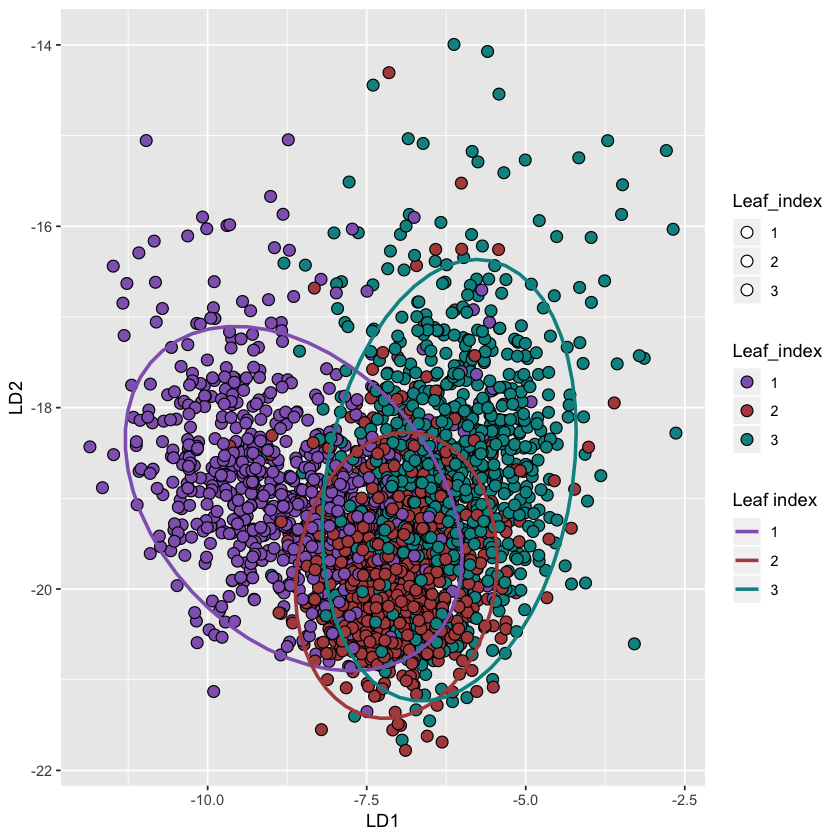

pdf 
  2

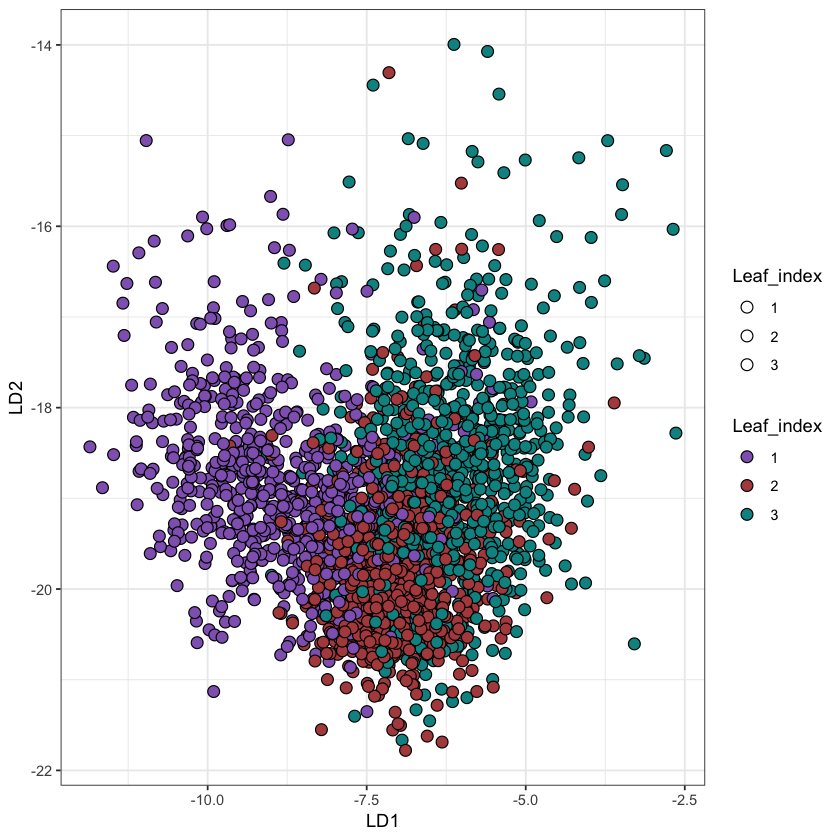

In [53]:
xcol <- rgb(145,102,189,maxColorValue=255)
ycol <- rgb(178,76,76,maxColorValue=255)
zcol <- rgb(0,146,146,maxColorValue=255)
#?rgb(255,182,119,maxColorValue=255))

d <- morpho_GPA_rotated_flat
y <- as.factor(morpho_meta$Leaf_index)
#y <- factor(y, levels=c(1,2,3))

lda <- lda(d,y)
lda.scale <- data.frame(lda$scaling)

lda.plot <- data.frame(LD1=apply(d, 1, dot, y=lda.scale$LD1), LD2=apply(d, 1, dot, y=lda.scale$LD2))
lda.plot$Leaf_index <- y

p <- ggplot(lda.plot, aes(x=LD1, y=LD2, fill=Leaf_index)) + 
  geom_point(aes(shape=Leaf_index), size=3) +
  stat_ellipse(aes(color=Leaf_index), linetype=1, size=1, level=0.95) + 
  scale_shape_manual(values=c(21, 21, 21, 21)) +
  scale_fill_manual(values=c(xcol, ycol, zcol), labels=c(1, 2, 3)) +  
  scale_color_manual(name="Leaf index", values=c(xcol, ycol, zcol), labels=c(1, 2, 3)) + 
  scale_y_continuous() +
  guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white")))

p

pdf('2017_morphology_LDA_leafIndex.pdf')
  p
dev.off()


p <- ggplot(lda.plot, aes(x=LD1, y=LD2, fill=Leaf_index)) + 
  geom_point(aes(shape=Leaf_index), size=3) +
  #stat_ellipse(aes(color=rootstock), linetype=1, size=1, level=0.95) + 
  scale_shape_manual(values=c(21, 21, 21, 21)) +
  scale_fill_manual(values=c(xcol, ycol, zcol), labels=c(1, 2, 3)) +  
  scale_color_manual(name="Leaf Index", values=c(xcol, ycol, zcol), labels=c(1, 2, 3)) + 
  scale_y_continuous() + theme_bw() + 
  guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white")))

p

pdf('2017_morphology_LDA_leafIndex_noEllipses.pdf')
  p
dev.off()

Warning message in lda.default(x, grouping, ...):
“variables are collinear”

png 
  2

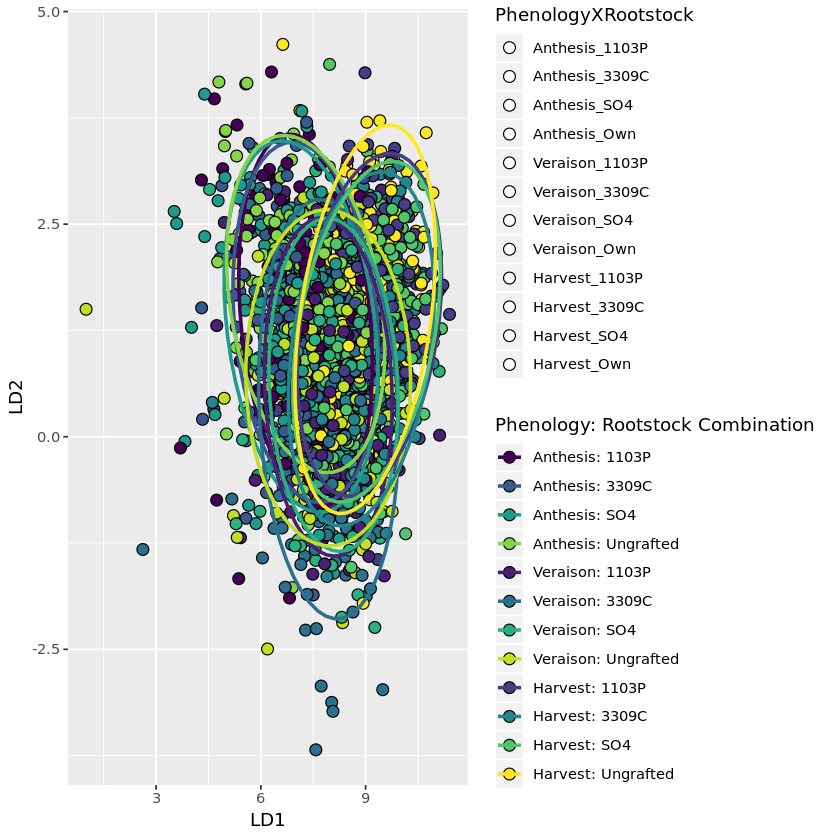

png 
  2

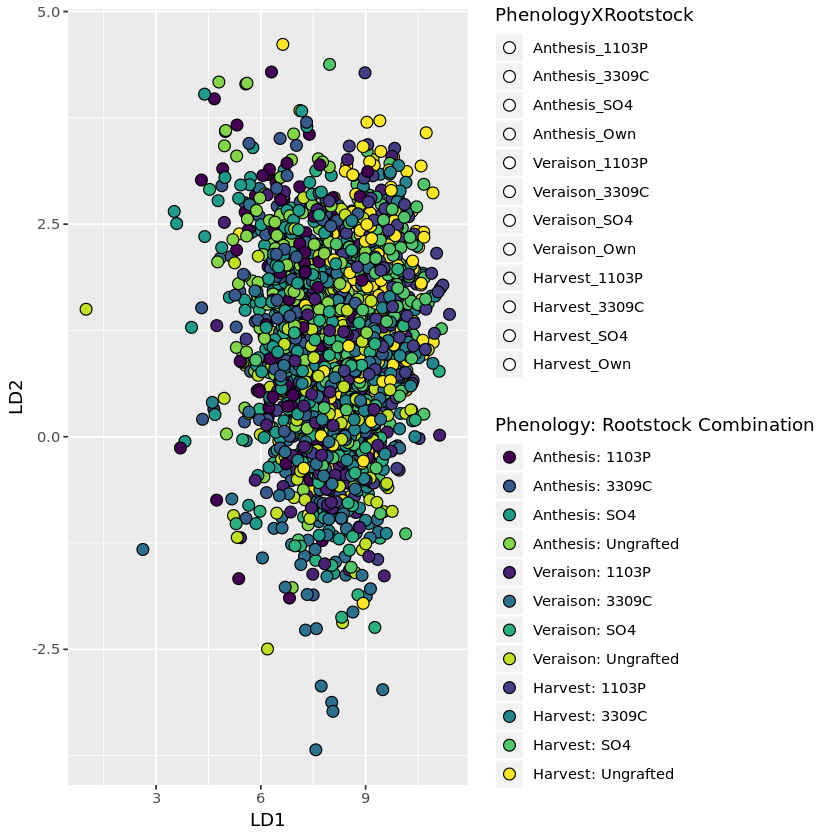

In [60]:
d <- morpho_GPA_rotated_flat
y <- paste(morpho_meta$Phenology, morpho_meta$Rootstock, sep='_')
lda <- lda(d,y)
lda.scale <- data.frame(lda$scaling)

lda.plot <- data.frame(LD1=apply(d, 1, dot, y=lda.scale$LD1), LD2=apply(d, 1, dot, y=lda.scale$LD2))
lda.plot$PhenologyXRootstock <- y
lda.plot$PhenologyXRootstock <- factor(lda.plot$PhenologyXRootstock, levels=c('Anthesis_1103P', 'Anthesis_3309C', 'Anthesis_SO4', 'Anthesis_Own',
                                  'Veraison_1103P', 'Veraison_3309C', 'Veraison_SO4', 'Veraison_Own',
                                  'Harvest_1103P', 'Harvest_3309C', 'Harvest_SO4', 'Harvest_Own'))

viridis_contrast <- viridis(12, option='viridis')[c(1, 4, 7, 10, 2, 5, 8, 11, 3, 6, 9, 12)]
#sample(viridis(12, option='viridis'), 12)


p <- ggplot(lda.plot, aes(x=LD1, y=LD2, fill=PhenologyXRootstock, shape=PhenologyXRootstock)) + 
     geom_point(size=3) + 
     scale_shape_manual(values=rep(21, 12)) + 
     stat_ellipse(aes(color=PhenologyXRootstock), linetype=1, size=1) + 
     scale_fill_manual(name="Phenology: Rootstock Combination", values=viridis_contrast, labels = c("Anthesis: 1103P", "Anthesis: 3309C", "Anthesis: SO4", "Anthesis: Ungrafted",
                                                                                                     "Veraison: 1103P", "Veraison: 3309C", "Veraison: SO4", "Veraison: Ungrafted",
                                                                                                     "Harvest: 1103P", "Harvest: 3309C", "Harvest: SO4", "Harvest: Ungrafted")) +
     scale_color_manual(name="Phenology: Rootstock Combination", values=viridis_contrast, labels = c("Anthesis: 1103P", "Anthesis: 3309C", "Anthesis: SO4", "Anthesis: Ungrafted",
                                                                                                     "Veraison: 1103P", "Veraison: 3309C", "Veraison: SO4", "Veraison: Ungrafted",
                                                                                                     "Harvest: 1103P", "Harvest: 3309C", "Harvest: SO4", "Harvest: Ungrafted")) +
     guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white")))

p

pdf('2017_morphology_LDA_phenologyRootstock.pdf')
  p
dev.off()

p <- ggplot(lda.plot, aes(x=LD1, y=LD2, fill=PhenologyXRootstock, shape=PhenologyXRootstock)) + 
     geom_point(size=3) + 
     scale_shape_manual(values=rep(21, 12)) + 
     #stat_ellipse(aes(color=PhenologyXRootstock), linetype=1, size=1) + 
     scale_fill_manual(name="Phenology: Rootstock Combination", values=viridis_contrast, labels = c("Anthesis: 1103P", "Anthesis: 3309C", "Anthesis: SO4", "Anthesis: Ungrafted",
                                                                                                     "Veraison: 1103P", "Veraison: 3309C", "Veraison: SO4", "Veraison: Ungrafted",
                                                                                                     "Harvest: 1103P", "Harvest: 3309C", "Harvest: SO4", "Harvest: Ungrafted")) +
     scale_color_manual(name="Phenology: Rootstock Combination", values=viridis_contrast, labels = c("Anthesis: 1103P", "Anthesis: 3309C", "Anthesis: SO4", "Anthesis: Ungrafted",
                                                                                                    "Veraison: 1103P", "Veraison: 3309C", "Veraison: SO4", "Veraison: Ungrafted",
                                                                                                    "Harvest: 1103P", "Harvest: 3309C", "Harvest: SO4", "Harvest: Ungrafted")) +
     guides(fill = guide_legend(override.aes = list(shape = 21)), shape = guide_legend(override.aes = list(fill = "white")))

p

pdf('2017_morphology_LDA_phenologyRootstock_noEllipses.pdf')
  p
dev.off()


## Main Figures for Shape

In [34]:
blade_colour <- "darkolivegreen"

plot_leafVar <- function(morpho_flat, blade_colour, title=''){   
    point_alpha <- 0.1
    line_alpha <- .25
    point_size <- 0.5
    line_size <- 0.75
    mean_line_size <- 1
    mean_line_colour <- "gray18"
    mean_line_alpha <- 1
       
    morpho_flat <- as.data.frame(morpho_flat)
    
    mean_leaf <- colMeans(morpho_flat)
    mean_leaf_plot <- as.data.frame(t(as.data.frame(mean_leaf)))
    m <- mean_leaf_plot

    p <- ggplot(morpho_flat, aes(x=x1, xend=x12, y=y1, yend=y12))
    p <- p + geom_segment(colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x12, xend=x10, y=y12, yend=y10), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x10, xend=x8, y=y10, yend=y8), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x8, xend=x6, y=y8, yend=y6), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x6, xend=x4, y=y6, yend=y4), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x4, xend=x2, y=y4, yend=y2), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x2, xend=x3, y=y2, yend=y3), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x3, xend=x5, y=y3, yend=y5), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x5, xend=x7, y=y5, yend=y7), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x7, xend=x9, y=y7, yend=y9), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x9, xend=x11, y=y9, yend=y11), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x11, xend=x1, y=y11, yend=y1), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_point(aes(x=x1, y=y1), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x2, y=y2), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x3, y=y3), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x4, y=y4), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x5, y=y5), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x6, y=y6), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x7, y=y7), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x8, y=y8), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x9, y=y9), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x10, y=y10), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x11, y=y11), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x12, y=y12), colour=blade_colour, alpha=point_alpha, size=point_size) +

         geom_segment(data=m, aes(x=x1, xend=x12, y=y1, yend=y12), colour=mean_line_colour, alpha=mean_line_alpha, size=mean_line_size) +
         geom_segment(data=m, aes(x=x12, xend=x10, y=y12, yend=y10), colour=mean_line_colour, alpha=mean_line_alpha, size=mean_line_size) +
         geom_segment(data=m, aes(x=x10, xend=x8, y=y10, yend=y8), colour=mean_line_colour, alpha=mean_line_alpha, size=mean_line_size) +
         geom_segment(data=m, aes(x=x8, xend=x6, y=y8, yend=y6), colour=mean_line_colour, alpha=mean_line_alpha, size=mean_line_size) +
         geom_segment(data=m, aes(x=x6, xend=x4, y=y6, yend=y4), colour=mean_line_colour, alpha=mean_line_alpha, size=mean_line_size) +
         geom_segment(data=m, aes(x=x4, xend=x2, y=y4, yend=y2), colour=mean_line_colour, alpha=mean_line_alpha, size=mean_line_size) +
         geom_segment(data=m, aes(x=x2, xend=x3, y=y2, yend=y3), colour=mean_line_colour, alpha=mean_line_alpha, size=mean_line_size) +
         geom_segment(data=m, aes(x=x3, xend=x5, y=y3, yend=y5), colour=mean_line_colour, alpha=mean_line_alpha, size=mean_line_size) +
         geom_segment(data=m, aes(x=x5, xend=x7, y=y5, yend=y7), colour=mean_line_colour, alpha=mean_line_alpha, size=mean_line_size) +
         geom_segment(data=m, aes(x=x7, xend=x9, y=y7, yend=y9), colour=mean_line_colour, alpha=mean_line_alpha, size=mean_line_size) +
         geom_segment(data=m, aes(x=x9, xend=x11, y=y9, yend=y11), colour=mean_line_colour, alpha=mean_line_alpha, size=mean_line_size) +
         geom_segment(data=m, aes(x=x11, xend=x1, y=y11, yend=y1), colour=mean_line_colour, alpha=mean_line_alpha, size=mean_line_size) +
         theme_bw() + 
         theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
         ggtitle(title)
    return(p)
}

plot_singleOutline <- function(leaf, blade_colour='grey18'){   
    point_alpha <- 1
    line_alpha <- 1.0
    point_size <- 1.25
    line_size <- 2.0
    
    p <- ggplot(leaf, aes(x=x1, xend=x12, y=y1, yend=y12))
    p <- p + geom_segment(colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x12, xend=x10, y=y12, yend=y10), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x10, xend=x8, y=y10, yend=y8), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x8, xend=x6, y=y8, yend=y6), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x6, xend=x4, y=y6, yend=y4), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x4, xend=x2, y=y4, yend=y2), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x2, xend=x3, y=y2, yend=y3), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x3, xend=x5, y=y3, yend=y5), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x5, xend=x7, y=y5, yend=y7), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x7, xend=x9, y=y7, yend=y9), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x9, xend=x11, y=y9, yend=y11), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_segment(aes(x=x11, xend=x1, y=y11, yend=y1), colour=blade_colour, alpha=line_alpha, size=line_size) +
         geom_point(aes(x=x1, y=y1), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x2, y=y2), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x3, y=y3), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x4, y=y4), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x5, y=y5), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x6, y=y6), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x7, y=y7), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x8, y=y8), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x9, y=y9), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x10, y=y10), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x11, y=y11), colour=blade_colour, alpha=point_alpha, size=point_size) +
         geom_point(aes(x=x12, y=y12), colour=blade_colour, alpha=point_alpha, size=point_size) +
         theme_bw() + 
         theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
    return(p)    
}

In [76]:
xcol <- rgb(145,102,189,maxColorValue=255)
ycol <- rgb(178,76,76,maxColorValue=255)
zcol <- rgb(0,146,146,maxColorValue=255)

a1 <- morpho_GPA_rotated_flat[morpho_meta$Phenology == 'Anthesis' & morpho_meta$Leaf_index == 1,]
a2 <- morpho_GPA_rotated_flat[morpho_meta$Phenology == 'Anthesis' & morpho_meta$Leaf_index == 2,]
a3 <- morpho_GPA_rotated_flat[morpho_meta$Phenology == 'Anthesis' & morpho_meta$Leaf_index == 3,]

v1 <- morpho_GPA_rotated_flat[morpho_meta$Phenology == 'Veraison' & morpho_meta$Leaf_index == 1,]
v2 <- morpho_GPA_rotated_flat[morpho_meta$Phenology == 'Veraison' & morpho_meta$Leaf_index == 2,]
v3 <- morpho_GPA_rotated_flat[morpho_meta$Phenology == 'Veraison' & morpho_meta$Leaf_index == 3,]

h1 <- morpho_GPA_rotated_flat[morpho_meta$Phenology == 'Harvest' & morpho_meta$Leaf_index == 1,]
h2 <- morpho_GPA_rotated_flat[morpho_meta$Phenology == 'Harvest' & morpho_meta$Leaf_index == 2,]
h3 <- morpho_GPA_rotated_flat[morpho_meta$Phenology == 'Harvest' & morpho_meta$Leaf_index == 3,]

p1 <- plot_leafVar(a1, xcol, 'a1')
p2 <- plot_leafVar(a2, ycol, 'a2')
p3 <- plot_leafVar(a3, zcol, 'a3')

p4 <- plot_leafVar(v1, xcol, 'v1')
p5 <- plot_leafVar(v2, ycol, 'v2')
p6 <- plot_leafVar(v3, zcol, 'v3')

p7 <- plot_leafVar(h1, xcol, 'h1')
p8 <- plot_leafVar(h2, ycol, 'h2')
p9 <- plot_leafVar(h3, zcol, 'h3')

pdf('2017_leafMorphology_leafVar_indexPhenology.pdf', onefile=T)
  p1 
  p2
  p3
  p4
  p5
  p6
  p7
  p8
  p9
dev.off()

png 
  2

In [35]:
levels(morpho_meta$Rootstock)

[1] "1103P" "3309C" "Own"   "SO4"

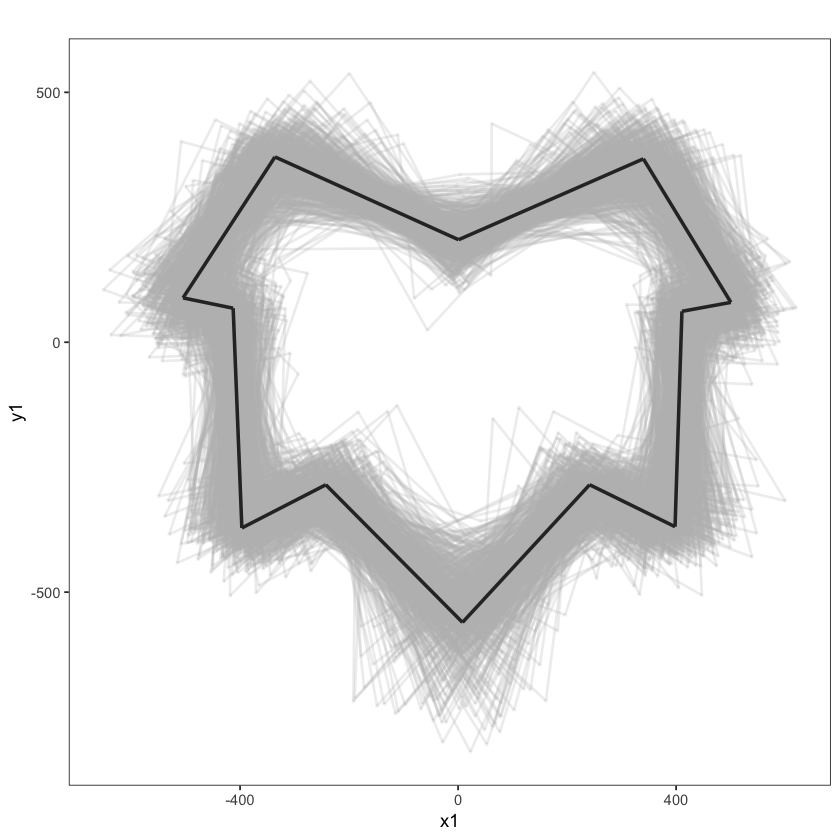

In [37]:
x <- morpho_GPA_rotated_flat[morpho_meta$Rootstock == 'Own',]
p1 <- plot_leafVar(x, rs_c_pal[1], '')
# x <- morpho_GPA_rotated_flat[morpho_meta$Rootstock == '1103P',]
# p2 <- plot_leafVar(x, rs_c_pal[2], '')
# x <- morpho_GPA_rotated_flat[morpho_meta$Rootstock == '3309C',]
# p3 <- plot_leafVar(x, rs_c_pal[3], '')
# x <- morpho_GPA_rotated_flat[morpho_meta$Rootstock == 'SO4',]
# p4 <- plot_leafVar(x, rs_c_pal[4], '')

# pdf('2017_morphplogy_rsVariation.pdf', height=4, width=16)
#   ggpubr::ggarrange(p1, p2, p3, p4, nrow=1)
# dev.off()

p1

In [64]:
x <- morpho_GPA_rotated_flat[morpho_meta$Leaf_index == 1,]
p1 <- plot_leafVar(x, xcol, '')
x <- morpho_GPA_rotated_flat[morpho_meta$Leaf_index == 2,]
p2 <- plot_leafVar(x, ycol, '')
x <- morpho_GPA_rotated_flat[morpho_meta$Leaf_index == 3,]
p3 <- plot_leafVar(x, zcol, '')

pdf('2017_morphplogy_pVariation.pdf', height=4, width=12)
  ggpubr::ggarrange(p1, p2, p3, nrow=1)
dev.off()

png 
  2

In [89]:
a1 <- morpho_pcs[morpho_meta$Phenology == 'Anthesis' & morpho_meta$Leaf_index == 1,]
a2 <- morpho_pcs[morpho_meta$Phenology == 'Anthesis' & morpho_meta$Leaf_index == 2,]
a3 <- morpho_pcs[morpho_meta$Phenology == 'Anthesis' & morpho_meta$Leaf_index == 3,]

v1 <- morpho_pcs[morpho_meta$Phenology == 'Veraison' & morpho_meta$Leaf_index == 1,]
v2 <- morpho_pcs[morpho_meta$Phenology == 'Veraison' & morpho_meta$Leaf_index == 2,]
v3 <- morpho_pcs[morpho_meta$Phenology == 'Veraison' & morpho_meta$Leaf_index == 3,]

h1 <- morpho_pcs[morpho_meta$Phenology == 'Harvest' & morpho_meta$Leaf_index == 1,]
h2 <- morpho_pcs[morpho_meta$Phenology == 'Harvest' & morpho_meta$Leaf_index == 2,]
h3 <- morpho_pcs[morpho_meta$Phenology == 'Harvest' & morpho_meta$Leaf_index == 3,]

In [61]:
a1

ERROR: Error in eval(expr, envir, enclos): object 'a1' not found


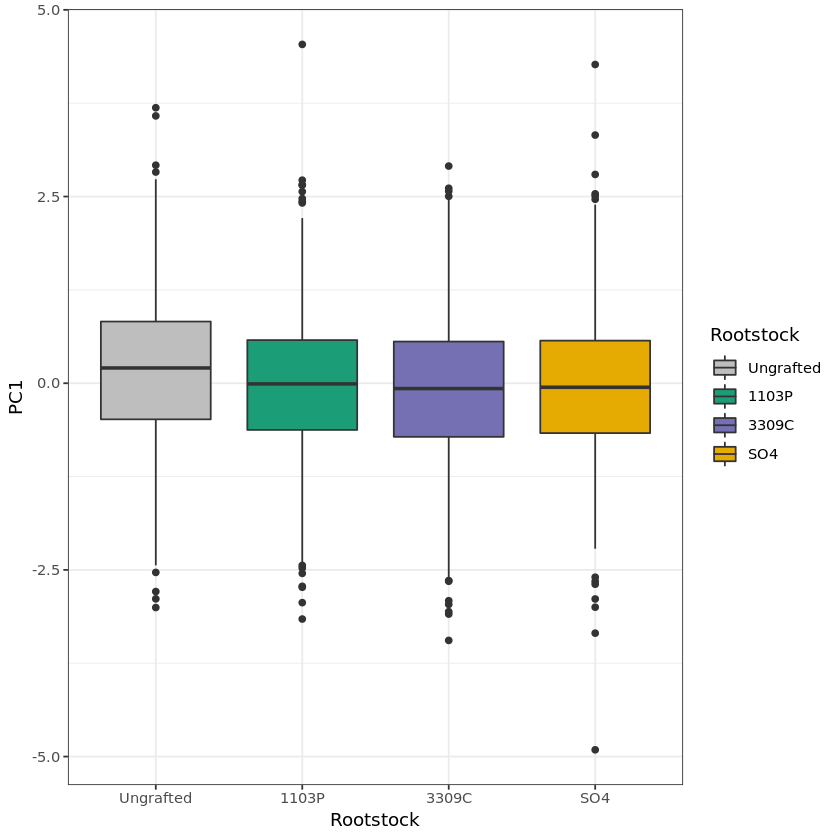

In [65]:
p <- ggplot(morpho_pcs, aes(x=Rootstock, y=PC1, fill=as.factor(Rootstock))) + 
     geom_boxplot() +
     scale_fill_manual(name='Rootstock', values=rs_c_pal) + 
     theme(panel.grid.major.x = element_blank(), panel.grid.minor.y = element_blank()) + theme_bw()  
     #facet_wrap('Phenology')
print(p)

pdf 
  2

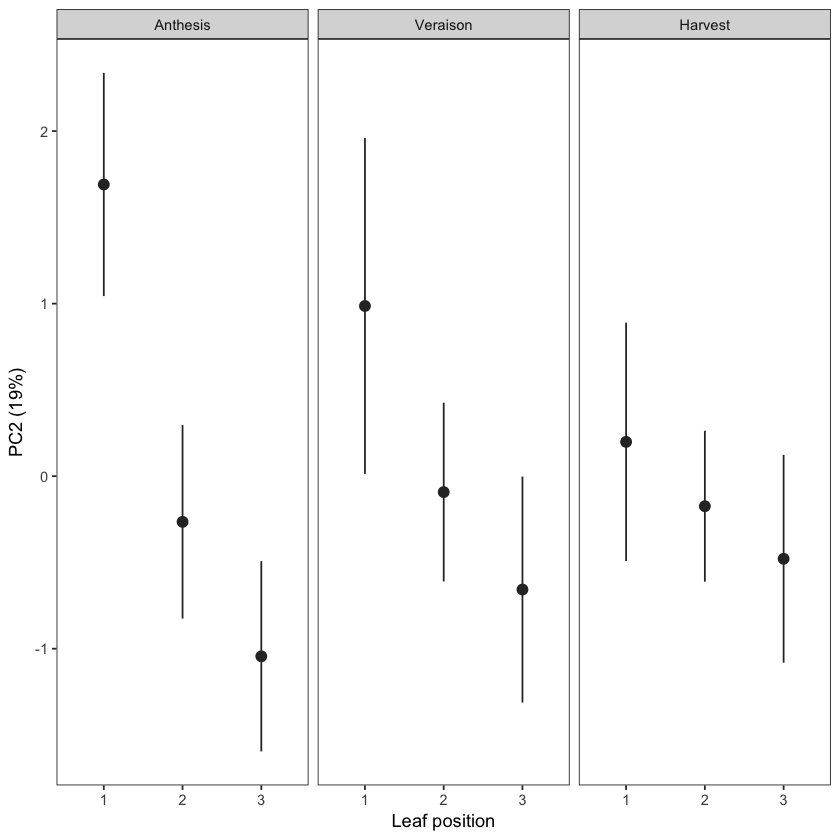

In [58]:
phen_li <- c('Anthesis_1', 'Anthesis_2', 'Anthesis_3', 'Veraison_1', 'Veraison_2', 'Veraison_3', 'Harvest_1', 'Harvest_2', 'Harvest_3')
morpho_pcs$phen_li <- paste(morpho_pcs$Phenology, morpho_pcs$Leaf_index, sep='_')
morpho_pcs_red <- morpho_pcs %>% dplyr::select(PC2, phen_li)

mf <- function(group){
    mean(morpho_pcs_red$PC2[morpho_pcs_red$phen_li == group])
}

sdf <- function(group){
    sd(morpho_pcs_red$PC2[morpho_pcs_red$phen_li == group])
}

morpho_pcs_red_plot <- data.frame(group=phen_li,
                                  Phenology=c(rep('Anthesis', 3), rep('Veraison', 3), rep('Harvest', 3)),
                                  Leaf_index=c(rep(c(1,2,3), 3)),
                                  means=unlist(lapply(phen_li, mf)),
                                  sds=unlist(lapply(phen_li, sdf)))

morpho_pcs_red_plot$Phenology <- factor(morpho_pcs_red_plot$Phenology, levels=c('Anthesis', 'Veraison', 'Harvest'))


pdf('2017_PC2_leafIndexPhenology.pdf', width=12, height=4)
p <- ggplot(morpho_pcs_red_plot, aes(as.factor(Leaf_index), y=means)) + 
     geom_pointrange(aes(ymin=means-sds, ymax=means+sds), colour='grey18') +
     labs(x='Leaf position', y='PC2 (19%)') +
     theme_bw() + 
     theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  facet_wrap('Phenology')
print(p)
dev.off()

p

In [57]:
pdf('2017_morphology_main_AB.pdf', width=8, height=4)
  ggpubr::ggarrange(morphFig1, morphFig2, ncol=2, labels=c('(a)', '(b)'))
dev.off()

pdf 
  2

In [70]:
find_closestLeaf <- function(optimal_value, vectorActualValues){
    #some of the values are negative, so we want to minimize the squared difference rather than just the difference
    v <- (vectorActualValues - optimal_value)^2
    sv <- sort(v, decreasing=FALSE)[1:20]
    v <- which(v %in% sv)
    return(v)
}

extract_andPlot <- function(x, y, z, title=''){
    x <- as.data.frame(t(colMeans(morpho_GPA_rotated_flat[x,])))
    x <- plot_singleOutline(x)
    y <- as.data.frame(t(colMeans(morpho_GPA_rotated_flat[y,])))
    y <- plot_singleOutline(y)
    z <- as.data.frame(t(colMeans(morpho_GPA_rotated_flat[z,])))
    z <- plot_singleOutline(z)
    pdf(title, width=12, height=4)
      print(ggpubr::ggarrange(z, x, y, ncol=3))
    dev.off()
}


pc1.m <- mean(morpho_pcs$PC1)
pc1.psd <- pc1.m + 3*sd(morpho_pcs$PC1)
pc1.p2sd <- pc1.m - 3*sd(morpho_pcs$PC1)
x <- find_closestLeaf(pc1.m, morpho_pcs$PC1)
y <- find_closestLeaf(pc1.p2sd, morpho_pcs$PC1)
z <- find_closestLeaf(pc1.m2sd, morpho_pcs$PC1)
extract_andPlot(x, y, z, "2017_morphology_PC1_shapes.pdf")

pc2.m <- mean(morpho_pcs$PC2)
pc2.p3sd <- pc2.m + 3*sd(morpho_pcs$PC2)
pc2.m3sd <- pc2.m - 3*sd(morpho_pcs$PC2)
x <- find_closestLeaf(pc2.m, morpho_pcs$PC2)
y <- find_closestLeaf(pc2.p3sd, morpho_pcs$PC2)
z <- find_closestLeaf(pc2.m3sd, morpho_pcs$PC2)
extract_andPlot(x, y, z, "2017_morphology_PC2_shapes.pdf")

pc3.m <- mean(morpho_pcs$PC3)
pc3.p3sd <- pc3.m + 3*sd(morpho_pcs$PC3)
pc3.m3sd <- pc3.m - 3*sd(morpho_pcs$PC3)
x <- find_closestLeaf(pc3.m, morpho_pcs$PC3)
y <- find_closestLeaf(pc3.p3sd, morpho_pcs$PC3)
z <- find_closestLeaf(pc3.m3sd, morpho_pcs$PC3)
extract_andPlot(x, y, z, "2017_morphology_PC3_shapes.pdf")

pc4.m <- mean(morpho_pcs$PC4)
pc4.p3sd <- pc4.m + 3*sd(morpho_pcs$PC4)
pc4.m3sd <- pc4.m - 3*sd(morpho_pcs$PC4)
x <- find_closestLeaf(pc4.m, morpho_pcs$PC4)
y <- find_closestLeaf(pc4.p3sd, morpho_pcs$PC4)
z <- find_closestLeaf(pc4.m3sd, morpho_pcs$PC4)
extract_andPlot(x, y, z, "2017_morphology_PC4_shapes.pdf")

pc5.m <- mean(morpho_pcs$PC5)
pc5.p3sd <- pc5.m + 3*sd(morpho_pcs$PC5)
pc5.m3sd <- pc5.m - 3*sd(morpho_pcs$PC5)
x <- find_closestLeaf(pc5.m, morpho_pcs$PC5)
y <- find_closestLeaf(pc5.p3sd, morpho_pcs$PC5)
z <- find_closestLeaf(pc5.m3sd, morpho_pcs$PC5)
extract_andPlot(x, y, z, "2017_morphology_PC5_shapes.pdf")

ERROR: Error in find_closestLeaf(pc1.m2sd, morpho_pcs$PC1): object 'pc1.m2sd' not found
